#### Imports and Helper Functions

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter


def ls_data(nPoints, mA, mB, sigmaA, sigmaB):
    classA = np.zeros((2, nPoints)) 
    classB = np.zeros((2, nPoints))
    classA[0] = np.random.randn(1, nPoints)*sigmaA+mA[0]
    classA[1] = np.random.randn(1, nPoints)*sigmaA+mA[1]
    classB[0] = np.random.randn(1, nPoints)*sigmaB+mB[0]
    classB[1] = np.random.randn(1, nPoints)*sigmaB+mB[1]
    return classA, classB
    
    
def shuffle_data(nPointsA, nPointsB,classA, classB, bias=True):
    data=np.concatenate((classA, classB), axis=1)
    if bias:
        data=np.concatenate((data,np.ones((1,nPointsA+nPointsB)))) #Add Bias
    labels=np.concatenate((np.ones(nPointsA),-np.ones(nPointsB)))
    shuffle=np.random.permutation(data.shape[1])
    return data[:,shuffle], labels[shuffle]


def calc_accuracy(X, T, W):
    correct = 0
    prediction = np.sign(W.dot(X))
    for i in range(len(prediction)):
        if T[i] == prediction[i]:
            correct += 1
    return correct/len(prediction)


def calc_mse(X, T, W):
    error = np.sign(W.dot(X)) - T
    return np.mean(np.square(error))


def delta_rule_batch(data, labels, weights, lr, epochs):
    X = data
    W = weights.copy()
    T = labels
    accuracy = []
    errors = []
    for i in range(epochs):
        error = W.dot(X) - T
        W = W - lr * error.dot(X.T)
        accuracy.append(calc_accuracy(X, T, W))
        errors.append(calc_mse(X,T,W))
    return W, accuracy, errors


def delta_rule_sequential(data, labels, weights, lr , epochs):
    X = data
    W = weights.copy()
    T = labels
    accuracy = []
    errors = []
    for i in range(epochs):
        for k in range(np.shape(X)[1]):
            error = T[k] - W.dot(X[:,k])
            W = W - lr * error*X[:,k]
        accuracy.append(calc_accuracy(X,T,W))
        errors.append(calc_mse(X,T,W))
    return W, accuracy, errors


def perceptron_learning(data, labels, weights, lr, epochs):
    X = data
    W = weights.copy()
    T = labels
    accuracy = []
    errors = []
    for i in range(epochs):
        Y = W.dot(X)
        for k in range(np.shape(X)[1]):
            if Y[k] < 0 and T[k] >=0:
                W = W + lr*X[:,k]
            elif Y[k] > 0 and T[k] <= 0:
                W = W - lr*X[:,k]
        accuracy.append(calc_accuracy(X,T,W))
        errors.append(calc_mse(X,T,W))
    return W, accuracy, errors
            
    
def data_313():
    n = 100
    mA = [1, 0.3]
    mB = [0, -0.1]
    sigmaA = 0.2
    sigmaB = 0.3
    classA = np.zeros((2, n)) 
    classB = np.zeros((2, n))
    classA[0] = np.concatenate((np.random.randn(1,50)*sigmaA-mA[0], np.random.randn(1,50)*sigmaA+mA[0]), axis=1)
    classA[1] = np.random.randn(1, n)*sigmaA+mA[1]
    classB[0] = np.random.randn(1, n)*sigmaB+mB[0]
    classB[1] = np.random.randn(1, n)*sigmaB+mB[1]
    return classA, classB


# Two-layer perceptron


def phi(h):
    return 2/(1+np.exp(-h))-1
    

def delta_phi(h):
    return 0.5*(1+h)*(1-h)


def forward_pass(X, W, V):
    Hin = W.dot(X)
    H = phi(Hin)
    H = np.concatenate((H, np.ones((1, np.shape(H)[1]))))
    Oin = V.dot(H)
    O = phi(Oin)
    return H, O


def backward_pass(T, V, H, O, nHidden):
    delta_O = (O-T)*delta_phi(O)
    delta_H = ((V.T).dot(delta_O))*delta_phi(H)
    delta_H = delta_H[0:nHidden]
    return delta_H,delta_O


def weight_update(X, W, V, dW, dV, H, delta_H, delta_O, alpha, lr):
    dW = dW*alpha - delta_H.dot(X.T) * (1-alpha)
    dV = (dV*alpha) - (delta_O.dot(H.T)) * (1-alpha)
    W = W+dW*lr
    V = V+dV*lr
    return W, V, dW, dV
    
    
def calc_mse2(O, T):
    return np.mean(np.square(O-T))


def calc_accuracy2(O, T):
    correct = 0
    prediction = np.sign(O)
    for i in range(prediction.shape[1]):
        if T[i] == prediction[0][i]:
            correct += 1
    return correct/prediction.shape[1]


def backprop(X, T, W, V, dW, dV, lr, X_test, T_test, epochs, nHidden, alpha=0.9, test = False):
    accuracy = []
    errors = []
    accuracy_test = []
    for i in range(epochs):
        H, O = forward_pass(X,W,V)
        accuracy.append(calc_accuracy2(O,T))
        errors.append(calc_mse2(O,T))
        if test:
            accuracy_test.append(calc_accuracy2(forward_pass(X_test,W,V)[1],T_test))
        delta_H,delta_O = backward_pass(T, V, H, O, nHidden)
        W, V, dW, dV = weight_update(X, W, V, dW, dV, H, delta_H, delta_O, alpha, lr)
    return W, V, accuracy, errors, accuracy_test


def predict(X, W, V):
    _, P = forward_pass(X, W, V)
    P = np.sign(P)
    return P

# https://stats.stackexchange.com/questions/71335/decision-boundary-plot-for-a-perceptron/71339#71339
def plot_boundary(X, T, W, V, classA, classB, classAV, classBV, test=False, h=0.02):
    #Create mesh
    x_min, x_max = X[0,:].min()-1,X[0,:].max()+1
    y_min, y_max = X[1,:].min()-1,X[1,:].max()+1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    #Make mesh data on same form as X
    grid_X = np.transpose(np.c_[xx.ravel(), yy.ravel()])
    grid_X = np.concatenate((grid_X, np.ones((1,grid_X.shape[1]))))
    #Plot decision boundary: Add color for each point in mesh
    fig, ax = plt.subplots()
    Z = predict(grid_X,W,V)
    Z = Z.reshape(xx.shape)
    ax.contourf(xx, yy, Z, cmap=plt.cm.Accent)
    ax.axis('off')
    #Plot training points
    ax.scatter(classA[0],classA[1],c='b',marker='+',label='classA')
    ax.scatter(classB[0], classB[1],c='r',marker='_',label='classB')
    #Plot validation points
    if test:
        if classAV.size != 0:
            ax.scatter(classAV[0],classAV[1],c='navy',marker='+',label='classA-val')
        if classBV.size != 0:
            ax.scatter(classBV[0], classBV[1],c='maroon',marker='_',label='classB-val')
    plt.show()
    
    
def plot_mse(errors):
    plt.plot(errors)
    plt.xlabel("Epochs")
    plt.ylabel("MSE")
    plt.title("Learning Curve for Backpropagation")
    plt.show()
    

def plot_acc(accuracy):
    plt.plot(accuracy)
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.title("Ratio of Correctly Classified Data for Backpropagation")
    plt.show()
    
    
def train_val_split_equal(X, T, val_percentage):
    X_train = []
    X_val = []
    T_train = []
    T_val = []
    countA = 0
    countB = 0
    n_A = round(X.shape[1]*val_percentage/2)
    n_B = round(X.shape[1]*val_percentage/2)
    for i in range(X.shape[1]):
        if T[i] > 0:
            if countA < n_A:
                X_val.append(X[:,i])
                T_val.append(T[i])
                countA +=1
            else:
                X_train.append(X[:,i])
                T_train.append(T[i])
        else:
            if countB < n_B:
                X_val.append(X[:,i])
                T_val.append(T[i])
                countB +=1
            else:
                X_train.append(X[:,i])
                T_train.append(T[i])
    return np.transpose(np.array(X_train)), np.transpose(np.array(X_val)), np.transpose(np.array(T_train)), np.transpose(np.array(T_val))


def train_val_split_A(X, T, val_percentage):
    X_train = []
    X_val = []
    T_train = []
    T_val = []
    countA = 0
    n_A = round(X.shape[1]*val_percentage/2)
    for i in range(X.shape[1]):
        if T[i] > 0:
            if countA < n_A:
                X_val.append(X[:,i])
                T_val.append(T[i])
                countA +=1
            else:
                X_train.append(X[:,i])
                T_train.append(T[i])
        else:
            X_train.append(X[:,i])
            T_train.append(T[i])
    return np.transpose(np.array(X_train)), np.transpose(np.array(X_val)), np.transpose(np.array(T_train)), np.transpose(np.array(T_val))


def train_val_split_B(X, T, val_percentage):
    X_train = []
    X_val = []
    T_train = []
    T_val = []
    countB = 0
    n_B = round(X.shape[1]*val_percentage/2)
    for i in range(X.shape[1]):
        if T[i] < 0:
            if countB < n_B:
                X_val.append(X[:,i])
                T_val.append(T[i])
                countB +=1
            else:
                X_train.append(X[:,i])
                T_train.append(T[i])
        else:
            X_train.append(X[:,i])
            T_train.append(T[i])
    return np.transpose(np.array(X_train)), np.transpose(np.array(X_val)), np.transpose(np.array(T_train)), np.transpose(np.array(T_val))


def train_val_split_AS(X, T, perc1, perc2):
    X_train = []
    X_val = []
    T_train = []
    T_val = []
    countA1 = 0
    countA2 = 0
    n_A1 = round(X.shape[1]*perc1/2)
    n_A2 = round(X.shape[1]*perc2/2)
    for i in range(X.shape[1]):
        if T[i] > 0:
            if countA1 < n_A1 and X[0,i] < 0:
                X_val.append(X[:,i])
                T_val.append(T[i])
                countA1 +=1
            elif countA2 < n_A2 and X[0,i]>0:
                X_val.append(X[:,i])
                T_val.append(T[i])
                countA2 +=1
            else:
                X_train.append(X[:,i])
                T_train.append(T[i])
        else:
            X_train.append(X[:,i])
            T_train.append(T[i])
    return np.transpose(np.array(X_train)), np.transpose(np.array(X_val)), np.transpose(np.array(T_train)), np.transpose(np.array(T_val))



def generate_classes(X, T):
    classA = []
    classB = []
    for i in range(X.shape[1]):
        if T[i] == 1:
            classA.append(X[:2,i])
        else:
            classB.append(X[:2,i])
    return np.transpose(np.array(classA)), np.transpose(np.array(classB))


def forward_pass_3D(X, W, V):
    Hin = W.dot(X)
    H = phi(Hin)
    H = np.concatenate((H, np.ones((1, np.shape(H)[1]))))
    Oin = V.dot(H)
    O = phi(Oin)
    
    gridsize = int(np.sqrt(X.shape[1]))
    zz = O.reshape(gridsize,gridsize)
    return H, O, zz


def backprop_3D(X, T, W, V, dW, dV, lr, X_test, T_test, epochs, nHidden, alpha=0.9, test = False):
    outputs = []
    accuracy = []
    errors = []
    outputs_test = []
    errors_test = []
    for i in range(epochs):
        H, O, zz = forward_pass_3D(X,W,V)
        outputs.append(zz)
        accuracy.append(calc_accuracy2(O,T))
        errors.append(calc_mse2(O,T))
        if test:
            H_test, O_test, zz_test = forward_pass_3D(X_test, W, V)
            outputs_test.append(zz_test)
            errors_test.append(calc_mse2(O_test,T_test))
        delta_H,delta_O = backward_pass(T, V, H, O, nHidden)
        W, V, dW, dV = weight_update(X, W, V, dW, dV, H, delta_H, delta_O, alpha, lr)
    return W, V, outputs, accuracy, errors, outputs_test, errors_test


def plot_3D(xx, yy, zz):
    plt.rcParams['figure.figsize'] = [10, 8]
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    surface = ax.plot_surface(xx, yy, zz, cmap=cm.RdBu, linewidth = 0, antialiased=False)
    ax.set_zlim(np.min(zz)-0.5, np.max(zz)+0.5)
    ax.zaxis.set_major_locator(LinearLocator(10))
    ax.zaxis.set_major_formatter(FormatStrFormatter('%02f'))
    fig.colorbar(surface, shrink=0.5, aspect=5)
    plt.show()
    
    
def shuffle_and_split(X, T, gridsize):
    shuffle=np.random.permutation(X.shape[1])
    X = X[:,shuffle]
    T = T [shuffle]
    trainIndex = gridsize**2
    return X[:,0:trainIndex], T[0:trainIndex], X[:,trainIndex:], T[trainIndex:]


def reverse_shuffle(outputs, shuffle):
    ordered_outputs = []
    gridsize = outputs.shape[0]
    outputs = np.reshape(outputs,(1,gridsize**2))
    for i in shuffle:
        ordered_outputs.append(outputs[0][i])
    ordered_outputs = np.reshape(ordered_outputs,(gridsize, gridsize))
    return ordered_outputs


def train_val_test_split(X, T, train, val):
    n = T.shape[1]
    train_n = int(n * train)
    val_n = int(n * (train + val))
    return X[:, :train_n], X[:, train_n:val_n], X[:, val_n:], T[0,:train_n], T[0, train_n:val_n], T[0,val_n:]

## Part 1

#### Generate linearly seperable data

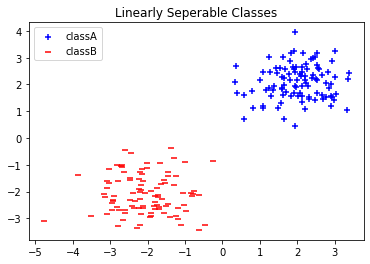

In [2]:
n = 100
classA, classB = ls_data(n, [2, 2], [-2, -2], 0.75, 0.75)

plt.scatter(classA[0],classA[1],c='b',marker='+',label='classA')
plt.scatter(classB[0], classB[1],c='r',marker='_',label='classB')
plt.legend(loc='upper left')
plt.title('Linearly Seperable Classes')
plt.show()

#### Concatenate and shuffe data

In [3]:
data,labels=shuffle_data(n, n, classA, classB)
weights = np.random.rand(data.shape[0])

#### Single layer perceptron 3.1.2

In [4]:
epochs = 100
lr = 0.001
W_drb, A_drb, E_drb = delta_rule_batch(data, labels, weights, lr, epochs)
W_drs, A_drs, E_drs = delta_rule_sequential(data, labels, weights, lr, epochs)
W_per, A_per, E_per = perceptron_learning(data, labels, weights, lr, epochs)

print(W_drb)
print(W_drs)
print(W_per)

[0.20852109 0.24849667 0.00534392]
[5.72617399e+76 5.91464327e+76 8.26691901e+74]
[0.60306479 0.08699439 0.2232713 ]


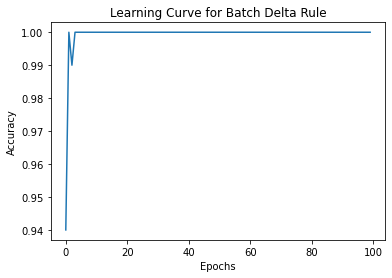

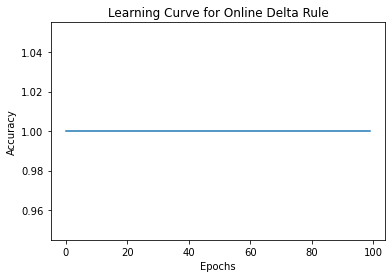

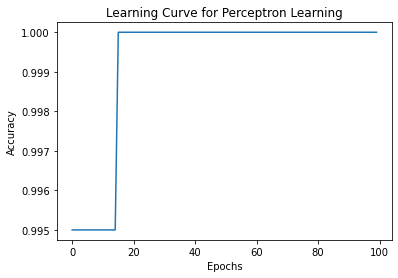

In [5]:
plt.plot(A_drb)
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Learning Curve for Batch Delta Rule")
plt.show()

plt.plot(A_drs)
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Learning Curve for Online Delta Rule")
plt.show()

plt.plot(A_per)
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Learning Curve for Perceptron Learning")
plt.show()

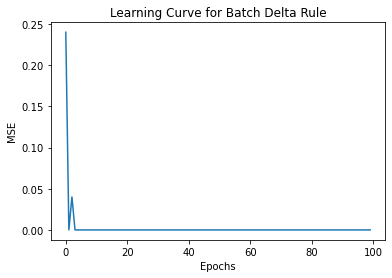

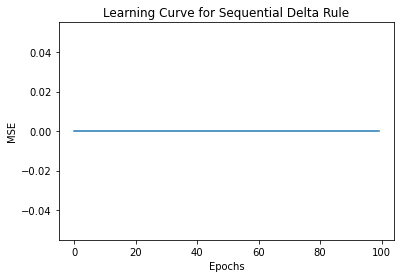

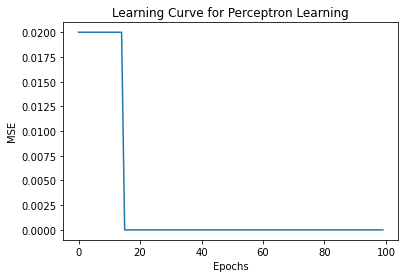

In [6]:
plt.plot(E_drb)
plt.xlabel("Epochs")
plt.ylabel("MSE")
plt.title("Learning Curve for Batch Delta Rule")
plt.show()

plt.plot(E_drs)
plt.xlabel("Epochs")
plt.ylabel("MSE")
plt.title("Learning Curve for Sequential Delta Rule")
plt.show()

plt.plot(E_per)
plt.xlabel("Epochs")
plt.ylabel("MSE")
plt.title("Learning Curve for Perceptron Learning")
plt.show()

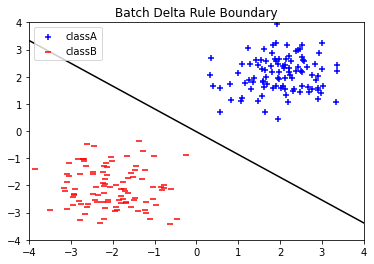

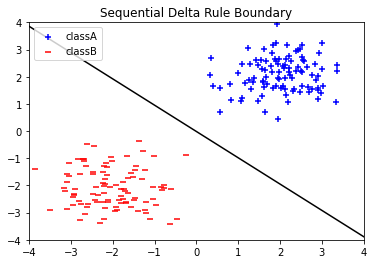

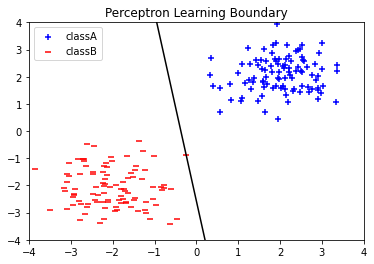

In [7]:
brange = np.linspace(-4, 4, 1000)
boundary_drb = -(W_drb[0]*brange+W_drb[2])/W_drb[1]
boundary_drs = -(W_drs[0]*brange+W_drs[2])/W_drs[1]
boundary_per = -(W_per[0]*brange+W_per[2])/W_per[1]

plt.scatter(classA[0],classA[1],c='b',marker='+',label='classA')
plt.scatter(classB[0], classB[1],c='r',marker='_',label='classB')
plt.plot(brange, boundary_drb, 'k-')
plt.xlim([-4, 4])
plt.ylim([-4, 4])
plt.legend(loc='upper left')
plt.title('Batch Delta Rule Boundary')
plt.show()

plt.figure()
plt.scatter(classA[0],classA[1],c='b',marker='+',label='classA')
plt.scatter(classB[0], classB[1],c='r',marker='_',label='classB')
plt.plot(brange, boundary_drs, 'k-')
plt.xlim([-4, 4])
plt.ylim([-4, 4])
plt.legend(loc='upper left')
plt.title('Sequential Delta Rule Boundary')
plt.show()

plt.figure()
plt.scatter(classA[0],classA[1],c='b',marker='+',label='classA')
plt.scatter(classB[0], classB[1],c='r',marker='_',label='classB')
plt.plot(brange, boundary_per, 'k-')
plt.xlim([-4, 4])
plt.ylim([-4, 4])
plt.legend(loc='upper left')
plt.title('Perceptron Learning Boundary')
plt.show()

### 3.1.2 Classification with a single-layer perceptron and analysis

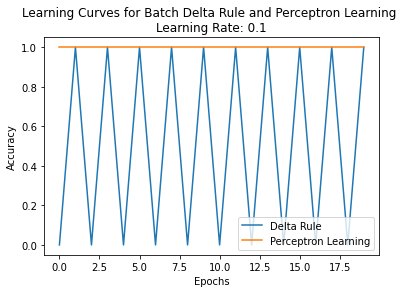

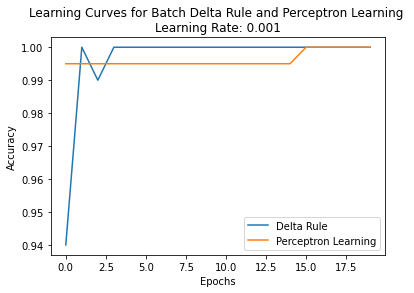

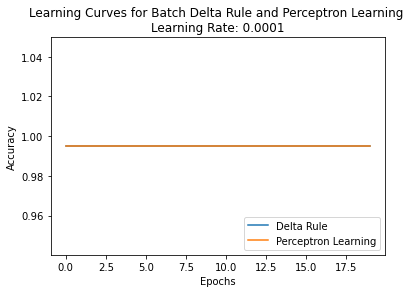

In [8]:
#3.1.2 Q1
epochs = 20
eta = [0.1, 0.001, 0.0001]
for lr in eta:    
    W_drb, A_drb, E_drb = delta_rule_batch(data, labels, weights, lr, epochs)
    W_per, A_per, E_per = perceptron_learning(data, labels, weights, lr, epochs)
    plt.plot(A_drb, label='Delta Rule')
    plt.plot(A_per, label='Perceptron Learning')
    plt.legend(loc='lower right')
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.title("Learning Curves for Batch Delta Rule and Perceptron Learning \n"+"Learning Rate: "+str(lr))
    plt.show()

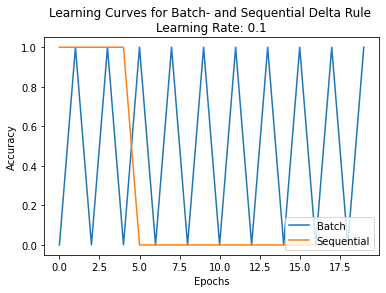

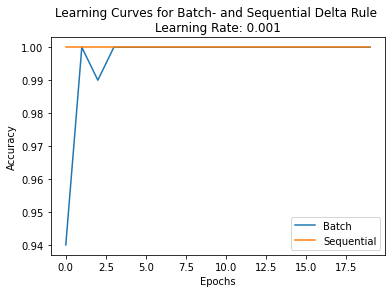

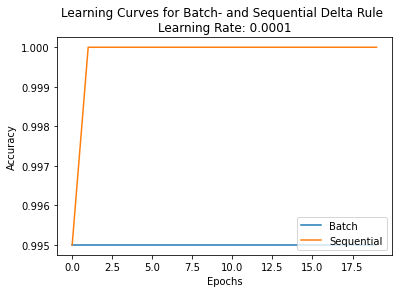

In [9]:
# 3.1.2 Q2
epochs = 20
eta = [0.1, 0.001, 0.0001]
for lr in eta:    
    W_drb, A_drb, E_drb = delta_rule_batch(data, labels, weights, lr, epochs)
    W_drs, A_drs, E_drs = delta_rule_sequential(data, labels, weights, lr, epochs)
    plt.plot(A_drb, label='Batch')
    plt.plot(A_drs, label='Sequential')
    plt.legend(loc='lower right')
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.title("Learning Curves for Batch- and Sequential Delta Rule \n"+"Learning Rate: "+str(lr))
    plt.show()

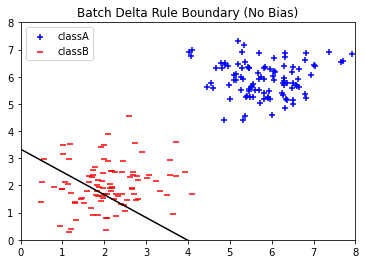

In [10]:
# 3.1.2 Q3
n = 100
classA_nb, classB_nb = ls_data(n, [6, 6], [2, 2], 0.75, 0.75)
data_nb, labels_nb = shuffle_data(n, n, classA_nb, classB_nb, False)
weights_nb = np.random.rand(data_nb.shape[0])

epochs = 100
lr = 0.001
W_drb, A_drb, E_drb = delta_rule_batch(data_nb, labels_nb, weights_nb, lr, epochs)
brange = np.linspace(0, 8, 1000)
boundary_drb_nb = -(W_drb[0]*brange)/W_drb[1]

plt.scatter(classA_nb[0],classA_nb[1],c='b',marker='+',label='classA')
plt.scatter(classB_nb[0], classB_nb[1],c='r',marker='_',label='classB')
plt.plot(brange, boundary_drb, 'k-')
plt.xlim([0, 8])
plt.ylim([0, 8])
plt.legend(loc='upper left')
plt.title('Batch Delta Rule Boundary (No Bias)')
plt.show()

#### 3.1.2 Questions
1. Batch Delta learning converges faster than Perceptron learning. The weights of Batch Delta diverge to excedingly large/low values for a sufficiently high learning rate, while the weights generated through Perceptron Learning appears more stable.

2. Sequential Delta learning converges faster than the Batch variant. It is also even more sensitive to adjustments in learning rate.

3. Without Bias the perceptron would succeed to correctly classify all data samples for any data which is linearly seperable by a line through origo. If the data is only linearly seperable by a line transposed from origo the Neural Network would fail to classify all samples.

## 3.1.3 Classification of samples that are not linearly seperable

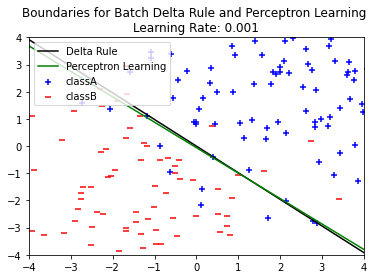

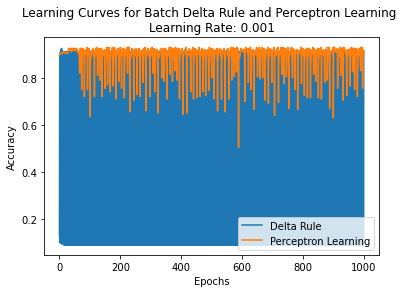

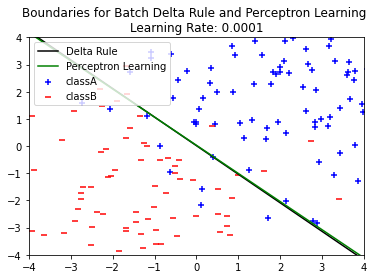

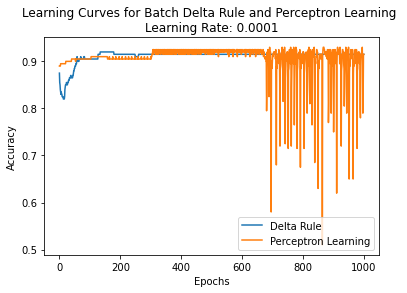

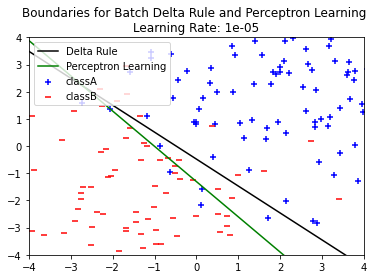

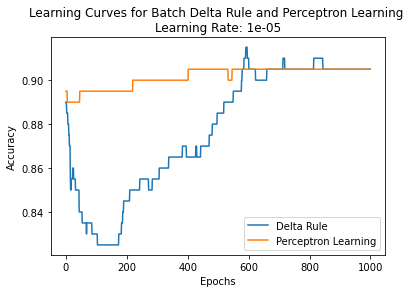

In [11]:
# Part 1
n = 100
classA, classB = ls_data(n, [2, 2], [-2, -2], 2, 2)
data,labels=shuffle_data(n, n, classA, classB)
weights = np.random.rand(data.shape[0])
epochs = 1000
eta = [0.001, 0.0001, 0.00001]
for lr in eta:    
    W_drb, A_drb, E_drb = delta_rule_batch(data, labels, weights, lr, epochs)
    W_per, A_per, E_per = perceptron_learning(data, labels, weights, lr, epochs)
    brange = np.linspace(-4, 4, 1000)
    boundary_drb = -(W_drb[0]*brange+W_drb[2])/W_drb[1]
    boundary_per = -(W_per[0]*brange+W_per[2])/W_per[1]
    plt.scatter(classA[0],classA[1],c='b',marker='+',label='classA')
    plt.scatter(classB[0], classB[1],c='r',marker='_',label='classB')
    plt.plot(brange, boundary_drb, 'k-', label='Delta Rule')
    plt.plot(brange, boundary_per, 'g-', label='Perceptron Learning')
    plt.xlim([-4, 4])
    plt.ylim([-4, 4])
    plt.legend(loc='upper left')
    plt.title("Boundaries for Batch Delta Rule and Perceptron Learning \n"+"Learning Rate: "+str(lr))
    plt.show()
    plt.figure()
    plt.plot(A_drb, label='Delta Rule')
    plt.plot(A_per, label='Perceptron Learning')
    plt.legend(loc='lower right')
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.title("Learning Curves for Batch Delta Rule and Perceptron Learning \n"+"Learning Rate: "+str(lr))
    plt.show()

### 3.1.3 Part1
Given enough epochs the boundaries of both Delta Rule and Perceptron Learning appear to converge to similar values. As was the case for linearly seperble data, Delta appear to converge faster, but is more sensitive to the learning rate and initial values.

In [12]:
# Part 2
n = 100
classA, classB = data_313()
weights = np.random.rand(data.shape[0])
data,labels=shuffle_data(n, n, classA, classB)

weights_25 = weights.copy()
classA_25 = np.zeros((2, 75))
classB_25 = np.zeros((2, 75))
data_25 = np.zeros((3, 150))
labels_25 = np.zeros(150)
countA = 0
countB = 0
index = 0
indexA = 0
indexB = 0
for i, label in enumerate(labels):
    if label == 1 and countA < 75:
        data_25[:,index]=data[:,i]
        labels_25[index]=label
        countA += 1
        index+=1
        classA_25[:,indexA]=data[:2,i]
        indexA+=1
    elif label == -1 and countB < 75:
        data_25[:,index]=data[:,i]
        labels_25[index]=label
        countB +=1
        index+=1
        classB_25[:,indexB]=data[:2,i]
        indexB+=1
    if index == 150:
        break

weights_50a = weights.copy()
classA_50a = np.zeros((2, 50))
classB_50a = classB
data_50a = np.zeros((3, 150))
labels_50a = np.zeros(150)
countA = 0
index = 0
indexA = 0
for i, label in enumerate(labels):
    if label == 1 and countA < 50:
        data_50a[:,index]=data[:,i]
        labels_50a[index]=label
        countA += 1
        index+=1
        classA_50a[:,indexA]=data[:2,i]
        indexA+=1
    elif label == -1:
        data_50a[:,index]=data[:,i]
        labels_50a[index]=label
        index+=1
    if index == 150:
        break

weights_50b = weights.copy()
classA_50b = classA
classB_50b = np.zeros((2, 50))
data_50b = np.zeros((3, 150))
labels_50b = np.zeros(150)
countB = 0
index = 0
indexB = 0
for i, label in enumerate(labels):
    if label == -1 and countB < 50:
        data_50b[:,index]=data[:,i]
        labels_50b[index]=label
        countB += 1
        index+=1
        classB_50b[:,indexB]=data[:2,i]
        indexB+=1
    elif label == 1:
        data_50b[:,index]=data[:,i]
        labels_50b[index]=label
        index+=1
    if index == 150:
        break

weights_a = weights.copy()
classA_a = np.zeros((2, 50))
classB_a = classB
data_a = np.zeros((3,150))
labels_a = np.zeros(150)
countP = 0
countN = 0
index = 0
indexA = 0
for i, label in enumerate(labels):
    if label == 1:
        if data[0,i] <0 and countN<10:
            data_a[:,index]=data[:,i]
            labels_a[index]=label
            countN+=1
            index+=1
            classA_a[:,indexA]=data[:2,i]
            indexA+=1
        elif data[0,i]>0 and countP<40:
            data_a[:,index]=data[:,i]
            labels_a[index]=label
            countP+=1
            index+=1
            classA_a[:,indexA]=data[:2,i]
            indexA+=1
    else:
        data_a[:,index]=data[:,i]
        labels_a[index]=label
        index+=1
    if index == 150:
        break

In [13]:
epochs = 5000
lr = 0.00001
W, A, E = delta_rule_batch(data, labels, weights, lr, epochs)
W_25, A_25, E_25 = delta_rule_batch(data_25, labels_25, weights_25, lr, epochs)
W_50a, A_50a, E_50a = delta_rule_batch(data_50a, labels_50a, weights_50a, lr, epochs)
W_50b, A_50b, E_50b = delta_rule_batch(data_50b, labels_50b, weights_50b, lr, epochs)
W_a, A_a, E_a = delta_rule_batch(data_a, labels_a, weights_a, lr, epochs)

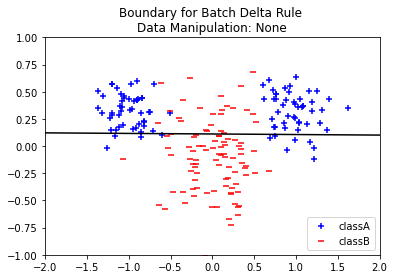

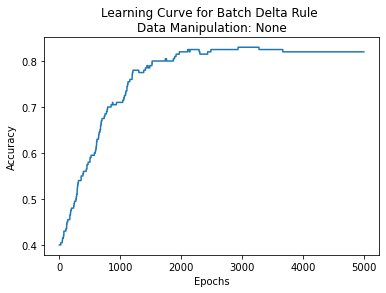

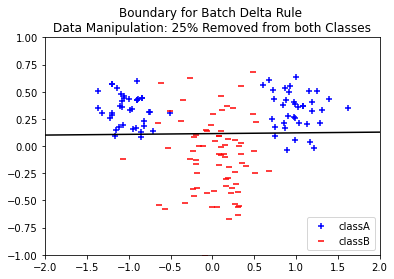

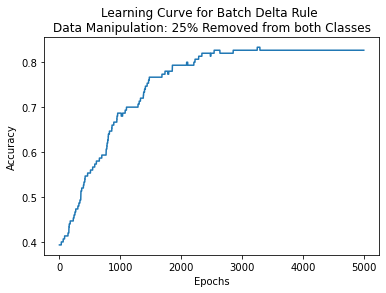

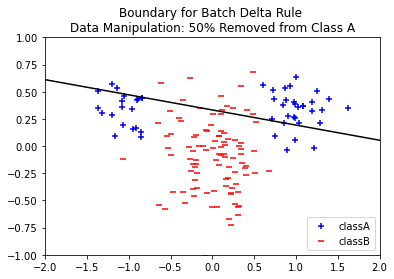

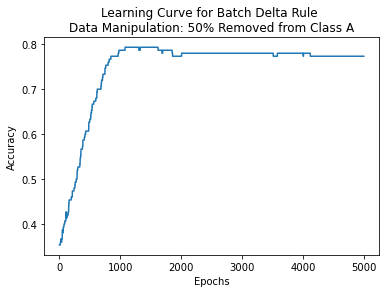

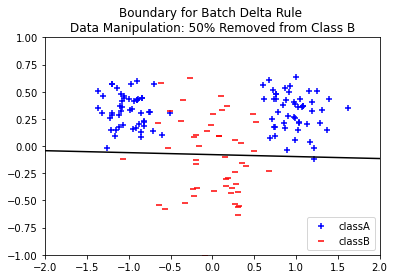

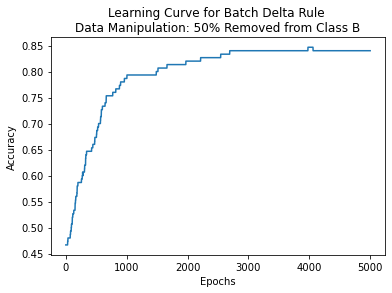

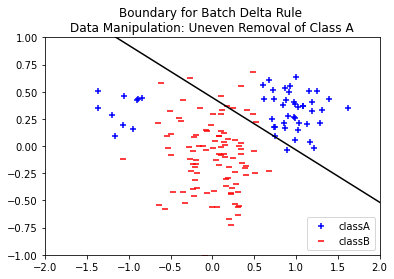

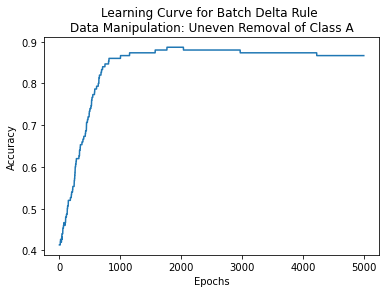

In [14]:
brange = np.linspace(-2, 2, 1000)
boundary = -(W[0]*brange+W[2])/W[1]
boundary_25 = -(W_25[0]*brange+W_25[2])/W_25[1]
boundary_50a = -(W_50a[0]*brange+W_50a[2])/W_50a[1]
boundary_50b = -(W_50b[0]*brange+W_50b[2])/W_50b[1]
boundary_a = -(W_a[0]*brange+W_a[2])/W_a[1]

plt.figure()
plt.scatter(classA[0],classA[1],c='b',marker='+',label='classA')
plt.scatter(classB[0], classB[1],c='r',marker='_',label='classB')
plt.plot(brange, boundary, 'k-')
plt.xlim([-2, 2])
plt.ylim([-1, 1])
plt.legend(loc='lower right')
plt.title("Boundary for Batch Delta Rule \n"+"Data Manipulation: None")
plt.show()
plt.figure()
plt.plot(A, label='Delta Rule')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Learning Curve for Batch Delta Rule \n"+"Data Manipulation: None")
plt.show()

plt.figure()
plt.scatter(classA_25[0],classA_25[1],c='b',marker='+',label='classA')
plt.scatter(classB_25[0], classB_25[1],c='r',marker='_',label='classB')
plt.plot(brange, boundary_25, 'k-')
plt.xlim([-2, 2])
plt.ylim([-1, 1])
plt.legend(loc='lower right')
plt.title("Boundary for Batch Delta Rule \n"+"Data Manipulation: 25% Removed from both Classes")
plt.show()
plt.figure()
plt.plot(A_25, label='Delta Rule')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Learning Curve for Batch Delta Rule \n"+"Data Manipulation: 25% Removed from both Classes")
plt.show()

plt.figure()
plt.scatter(classA_50a[0],classA_50a[1],c='b',marker='+',label='classA')
plt.scatter(classB_50a[0], classB_50a[1],c='r',marker='_',label='classB')
plt.plot(brange, boundary_50a, 'k-')
plt.xlim([-2, 2])
plt.ylim([-1, 1])
plt.legend(loc='lower right')
plt.title("Boundary for Batch Delta Rule \n"+"Data Manipulation: 50% Removed from Class A")
plt.show()
plt.figure()
plt.plot(A_50a, label='Delta Rule')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Learning Curve for Batch Delta Rule \n"+"Data Manipulation: 50% Removed from Class A")
plt.show()

plt.figure()
plt.scatter(classA_50b[0],classA_50b[1],c='b',marker='+',label='classA')
plt.scatter(classB_50b[0], classB_50b[1],c='r',marker='_',label='classB')
plt.plot(brange, boundary_50b, 'k-')
plt.xlim([-2, 2])
plt.ylim([-1, 1])
plt.legend(loc='lower right')
plt.title("Boundary for Batch Delta Rule \n"+"Data Manipulation: 50% Removed from Class B")
plt.show()
plt.figure()
plt.plot(A_50b, label='Delta Rule')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Learning Curve for Batch Delta Rule \n"+"Data Manipulation: 50% Removed from Class B")
plt.show()

plt.figure()
plt.scatter(classA_a[0],classA_a[1],c='b',marker='+',label='classA')
plt.scatter(classB_a[0], classB_a[1],c='r',marker='_',label='classB')
plt.plot(brange, boundary_a, 'k-')
plt.xlim([-2, 2])
plt.ylim([-1, 1])
plt.legend(loc='lower right')
plt.title("Boundary for Batch Delta Rule \n"+"Data Manipulation: Uneven Removal of Class A")
plt.show()
plt.figure()
plt.plot(A_a, label='Delta Rule')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Learning Curve for Batch Delta Rule \n"+"Data Manipulation: Uneven Removal of Class A")
plt.show()

### 3.1.3 Part 2
Alternative sub-samples generate significantly different decision boundaries. Of particular note is the final case where the sample contained a skewed view of class A, this resulted in a decision boundary which completely ignores a subset of A which we know to constitute 50% of an average class data sample. Uneven distribution between classes also has a profound effect on the resulting decision boundary, while the smaller but representative sample performed almost as well as the complete sample. We conclude that the most important aspect of a sample is that it's representative of the studied system.

## Two-layer Perceptron
### 3.2.1 Classification of linearly non-seperable data

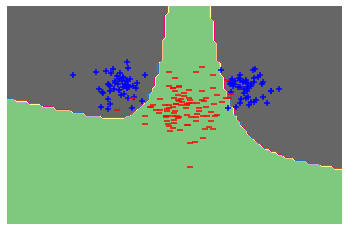

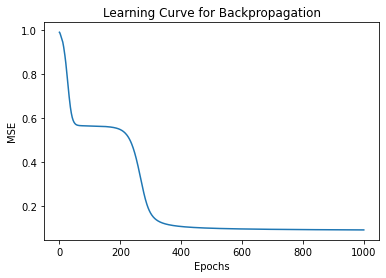

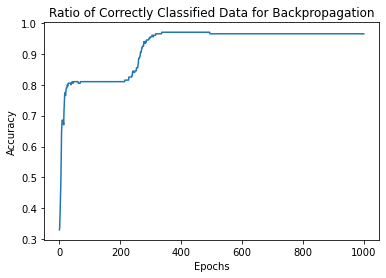

In [115]:
epochs = 1000
lr = 0.01
nHidden = 4
classA, classB = data_313()
X,T=shuffle_data(n, n, classA, classB)
W = np.random.rand(nHidden,X.shape[0])
V = np.random.rand(1,nHidden+1)
dW = np.zeros((W.shape[0], W.shape[1]))
dV = np.zeros((V.shape[0], V.shape[1]))

W, V, accuracy, errors, accuracy_test = backprop(X, T, W, V, dW, dV, lr, None, None, epochs, nHidden, alpha=0.9, test = False)
plot_boundary(X, T, W, V, classA, classB,None, None, h=0.05)
plot_mse(errors)
plot_acc(accuracy)

#### 3.2.1 Q1
Vary hidden nodes.

Epochs: 1000, Learning Rate: 0.01, Hidden Layers: 1


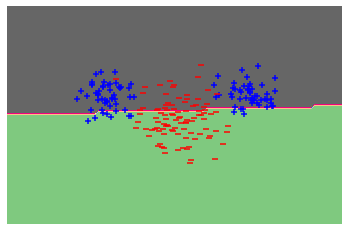

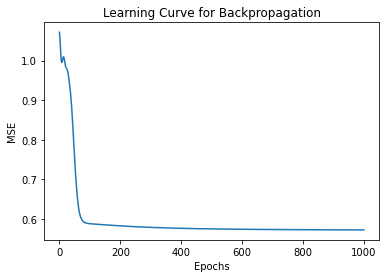

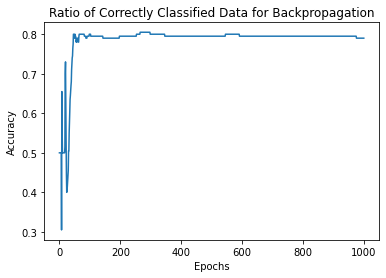

Epochs: 1000, Learning Rate: 0.01, Hidden Layers: 2


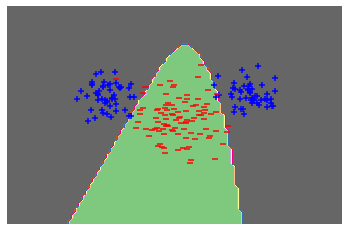

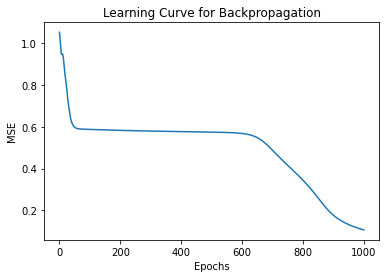

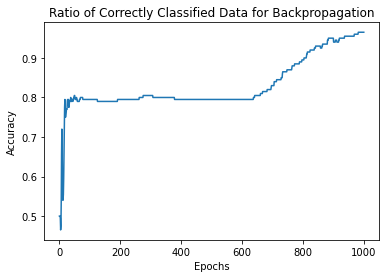

Epochs: 1000, Learning Rate: 0.01, Hidden Layers: 4


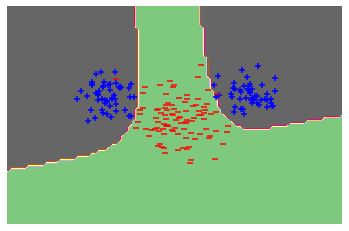

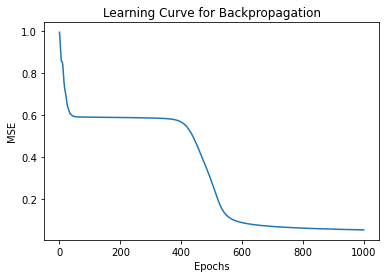

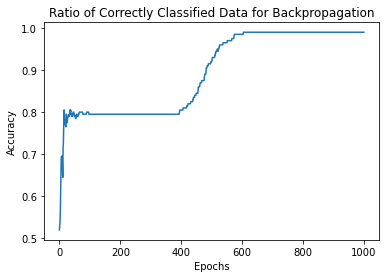

Epochs: 1000, Learning Rate: 0.01, Hidden Layers: 8


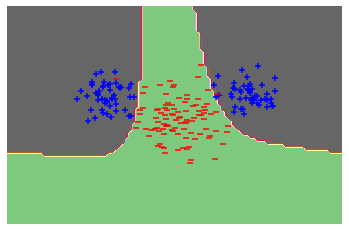

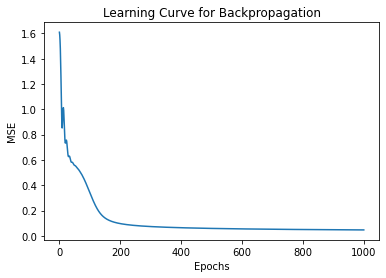

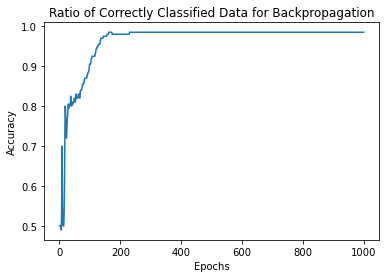

Epochs: 1000, Learning Rate: 0.01, Hidden Layers: 16


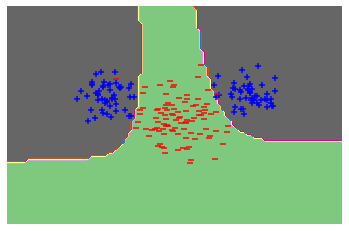

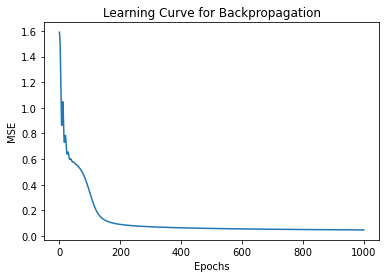

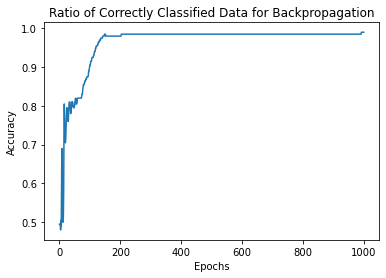

In [91]:
n = 100
epochs = 1000
lr = 0.01
nHiddens = [1,2,4,8,16]
classA, classB = data_313()
X,T=shuffle_data(n, n, classA, classB)

for nHidden in nHiddens:
    W = np.random.rand(nHidden,X.shape[0])
    V = np.random.rand(1,nHidden+1)
    dW = np.zeros((W.shape[0], W.shape[1]))
    dV = np.zeros((V.shape[0], V.shape[1]))
    print(f"Epochs: {epochs}, Learning Rate: {lr}, Hidden Layers: {nHidden}")
    W, V, accuracy, errors, accuracy_test = backprop(X, T, W, V, dW, dV, lr, None, None, epochs, nHidden, alpha=0.9, test = False)
    plot_boundary(X, T, W, V, classA, classB, h=0.05)
    plot_mse(errors)
    plot_acc(accuracy)

#### 3.2.1 Q2
Training and Validation subsamples.

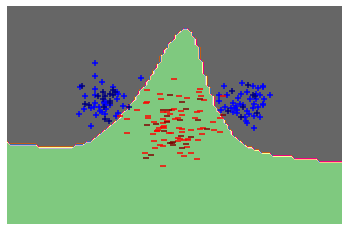

Training accuracy, Final: 0.9933333333333333


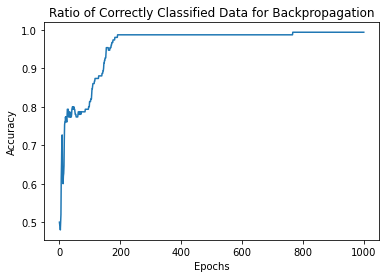

Validation accuracy, Final: 0.96


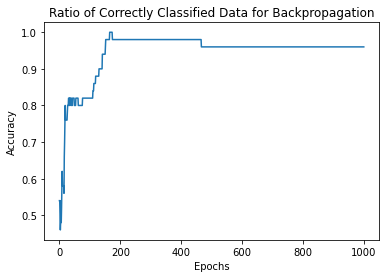

In [142]:
epochs = 1000
lr = 0.01
nHidden = 8

classA, classB = data_313()
X,T=shuffle_data(n, n, classA, classB)
X_train25, X_val25, T_train25, T_val25 = train_val_split_equal(X, T, 0.25)
classA_train25, classB_train25 = generate_classes(X_train25, T_train25)
classA_val25, classB_val25 = generate_classes(X_val25, T_val25)
W = np.random.rand(nHidden,X_train25.shape[0])
V = np.random.rand(1,nHidden+1)
dW = np.zeros((W.shape[0], W.shape[1]))
dV = np.zeros((V.shape[0], V.shape[1]))

W, V, accuracy, errors, accuracy_val = backprop(X_train25, T_train25, W, V, dW, dV, lr, X_val25, T_val25, epochs, nHidden, alpha=0.9, test = True)
plot_boundary(X_train25, T_train25, W, V, classA_train25, classB_train25, classA_val25, classB_val25, test=True, h=0.05)
print(f"Training accuracy, Final: {accuracy[-1]}")
plot_acc(accuracy)
print(f"Validation accuracy, Final: {accuracy_val[-1]}")
plot_acc(accuracy_val)

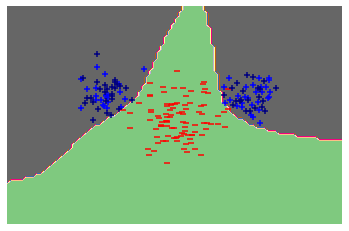

Training accuracy, Final: 0.9866666666666667


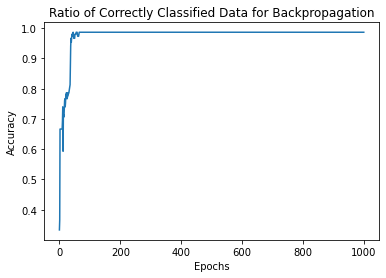

Validation accuracy, Final: 1.0


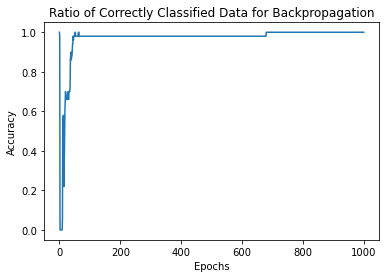

In [146]:
epochs = 1000
lr = 0.1
nHidden = 8

X_trainA50, X_valA50, T_trainA50, T_valA50 = train_val_split_A(X, T, 0.5)
classA_trainA50, classB_trainA50 = generate_classes(X_trainA50, T_trainA50)
classA_valA50, classB_valA50 = generate_classes(X_valA50, T_valA50)
W = np.random.rand(nHidden,X_trainA50.shape[0])
V = np.random.rand(1,nHidden+1)
dW = np.zeros((W.shape[0], W.shape[1]))
dV = np.zeros((V.shape[0], V.shape[1]))

W, V, accuracy, errors, accuracy_val = backprop(X_trainA50, T_trainA50, W, V, dW, dV, lr, X_valA50, T_valA50, epochs, nHidden, alpha=0.9, test = True)
plot_boundary(X_trainA50, T_trainA50, W, V, classA_trainA50, classB_trainA50, classA_valA50, classB_valA50, test=True, h=0.05)
print(f"Training accuracy, Final: {accuracy[-1]}")
plot_acc(accuracy)
print(f"Validation accuracy, Final: {accuracy_val[-1]}")
plot_acc(accuracy_val)

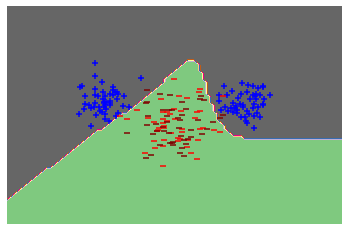

Training accuracy, Final: 0.9933333333333333


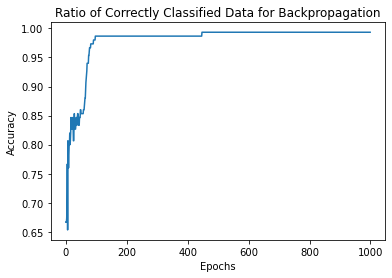

Validation accuracy, Final: 0.94


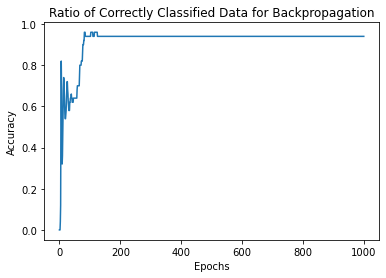

In [147]:
epochs = 1000
lr = 0.1
nHidden = 16

X_trainB50, X_valB50, T_trainB50, T_valB50 = train_val_split_B(X, T, 0.5)
classA_trainB50, classB_trainB50 = generate_classes(X_trainB50, T_trainB50)
classA_valB50, classB_valB50 = generate_classes(X_valB50, T_valB50)
W = np.random.rand(nHidden,X_trainB50.shape[0])
V = np.random.rand(1,nHidden+1)
dW = np.zeros((W.shape[0], W.shape[1]))
dV = np.zeros((V.shape[0], V.shape[1]))

W, V, accuracy, errors, accuracy_val = backprop(X_trainB50, T_trainB50, W, V, dW, dV, lr, X_valB50, T_valB50, epochs, nHidden, alpha=0.9, test = True)
plot_boundary(X_trainB50, T_trainB50, W, V, classA_trainB50, classB_trainB50, classA_valB50, classB_valB50, test=True, h=0.05)
print(f"Training accuracy, Final: {accuracy[-1]}")
plot_acc(accuracy)
print(f"Validation accuracy, Final: {accuracy_val[-1]}")
plot_acc(accuracy_val)

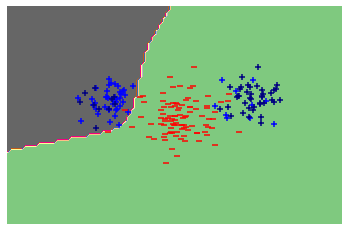

Training accuracy, Final: 0.9266666666666666


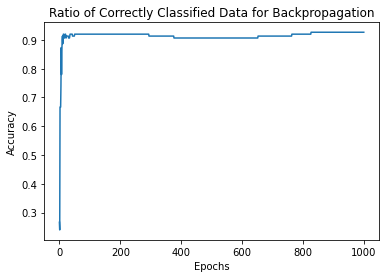

Validation accuracy, Final: 0.2


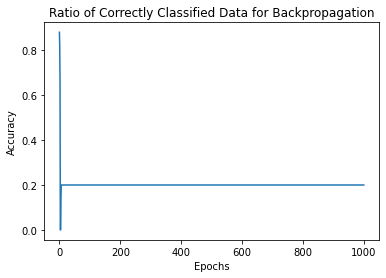

In [137]:
epochs = 1000
lr = 0.1
nHidden = 16

X_trainAS, X_valAS, T_trainAS, T_valAS = train_val_split_AS(X, T, 0.1, 0.4)
classA_trainAS, classB_trainAS = generate_classes(X_trainAS, T_trainAS)
classA_valAS, classB_valAS = generate_classes(X_valAS, T_valAS)
W = np.random.rand(nHidden,X_trainAS.shape[0])
V = np.random.rand(1,nHidden+1)
dW = np.zeros((W.shape[0], W.shape[1]))
dV = np.zeros((V.shape[0], V.shape[1]))

W, V, accuracy, errors, accuracy_val = backprop(X_trainAS, T_trainAS, W, V, dW, dV, lr, X_valAS, T_valAS, epochs, nHidden, alpha=0.9, test = True)
plot_boundary(X_trainAS, T_trainAS, W, V, classA_trainAS, classB_trainAS, classA_valAS, classB_valAS, test=True, h=0.05)
print(f"Training accuracy, Final: {accuracy[-1]}")
plot_acc(accuracy)
print(f"Validation accuracy, Final: {accuracy_val[-1]}")
plot_acc(accuracy_val)

### 3.2.1 Questions
Q1. We did not manage to perfectly classify the data no matter the number of hidden nodes. Two hidden nodes were sufficient to achieve an intuitive looking boundary layer. It would however not generalize well if classB extends towards higher y-values.

Q2.
* The error curves are similar for both training and validation sets, except for the final case of a misrepresentative training classA sample. Further proving that representative data is important.
* With a too low amount of hidden nodes, the network fails to capture the general shape of the data. If the number of hidden nodes is set too large, the networks tend to overfit. The effects of overfitting varies depending on the distribution of training and validation sets.
* Not tested. I speculate that the difference would be small, and that the sequential network would perform slightly worse depending of the order of data samples and potential outliers.
* Decision boundary was approximated by dividing graph into a fine grid, and performing classification on each grid point.

### 3.2.3 Function Approximation

(20, 20)


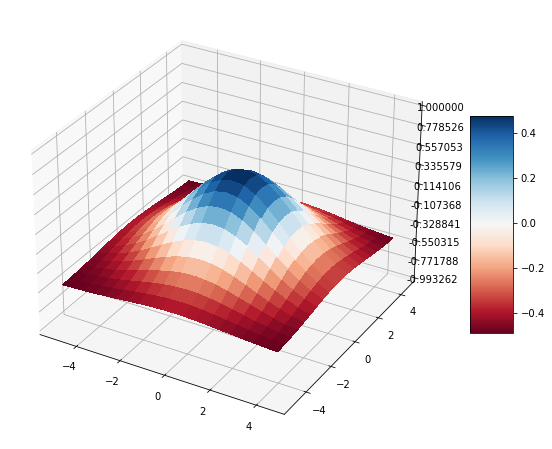

In [33]:
# Print function
def f(x,y):
    return np.exp(-(x**2+y**2)/10)-0.5

x = np.arange(-5,5,0.5)
y = np.arange(-5,5,0.5)
xx, yy = np.meshgrid(x, y)
zz = f(xx, yy)

plot_3D(xx, yy, zz)

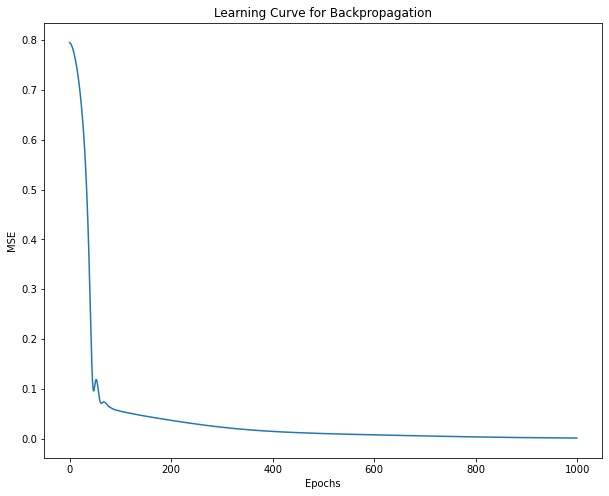

In [39]:
# Train the network and visualise the approximated function
epochs = 1000
lr = 0.001
nHidden = 16


ndata = len(xx)*len(yy)
T = zz.reshape(ndata).copy()
X = np.vstack([np.reshape(xx, (1, ndata)), np.reshape(yy,(1,ndata))])
X = np.vstack([X, np.ones(X.shape[1])])
W = np.random.rand(nHidden,X.shape[0])
V = np.random.rand(1,nHidden+1)
dW = np.zeros((W.shape[0], W.shape[1]))
dV = np.zeros((V.shape[0], V.shape[1]))
X_test = None
T_test = None

W, V, outputs, accuracy, errors, outputs_test, accuracy_test = backprop_3D(X, T, W, V, dW, dV, lr, X_test, T_test, epochs, nHidden, alpha=0.9, test = False)

plot_mse(errors)

Surface after 0 epochs


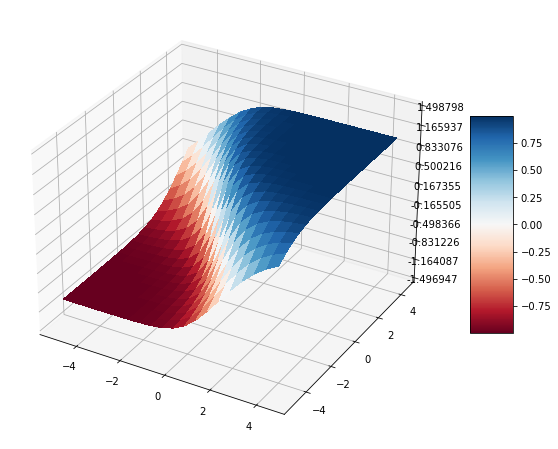

Surface after 100 epochs


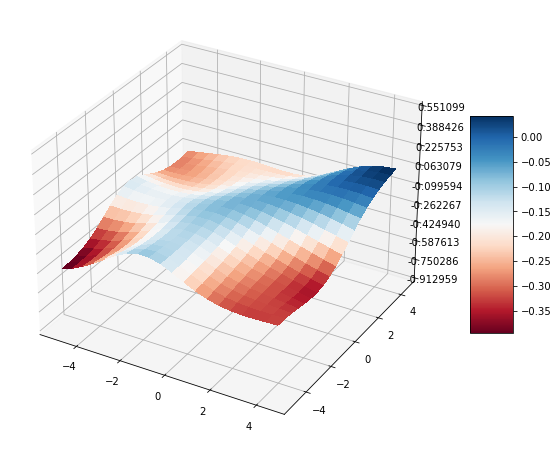

Surface after 200 epochs


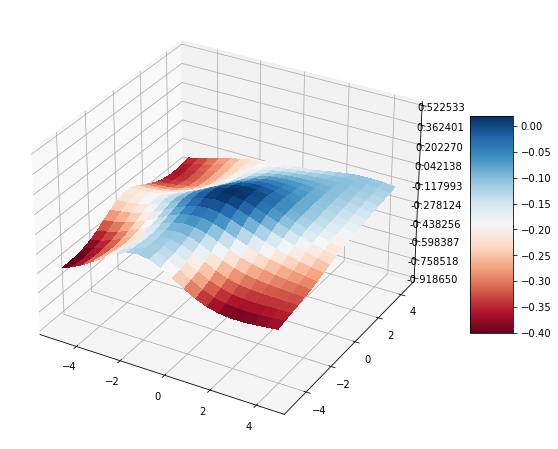

Surface after 300 epochs


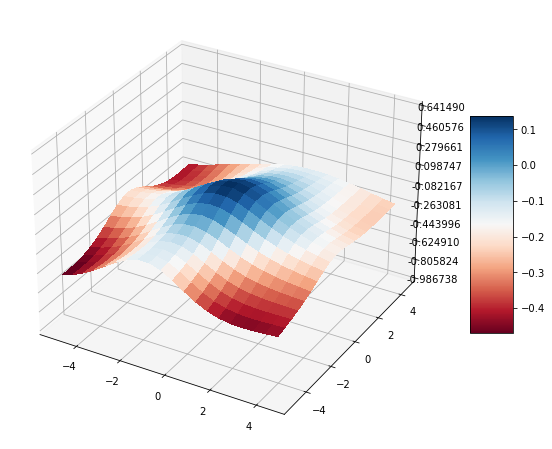

Surface after 400 epochs


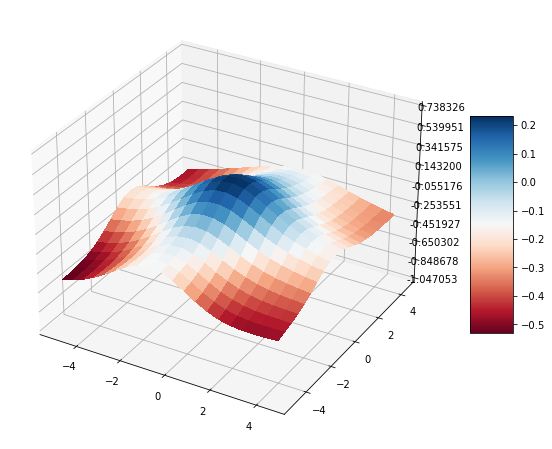

Surface after 500 epochs


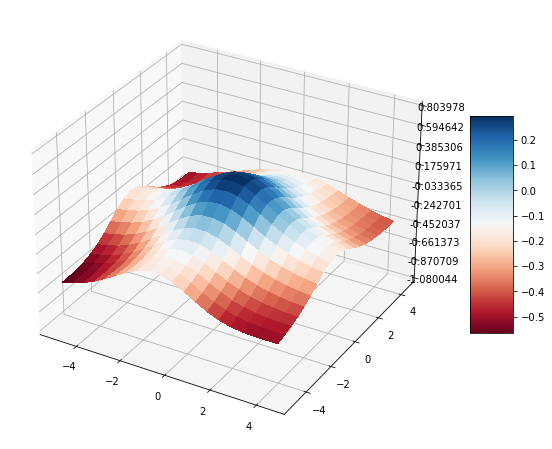

Surface after 600 epochs


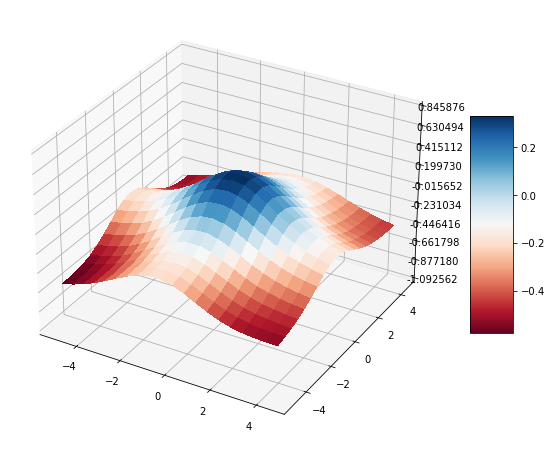

Surface after 700 epochs


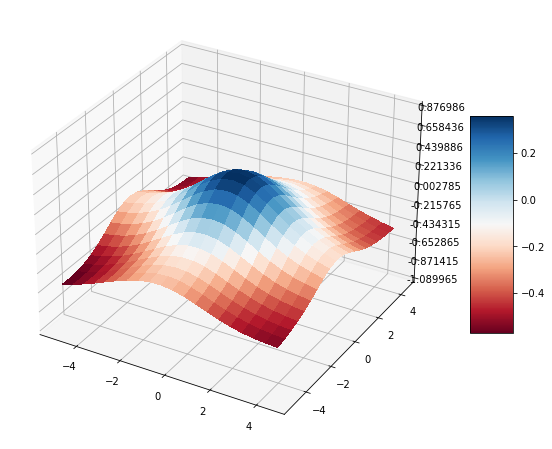

Surface after 800 epochs


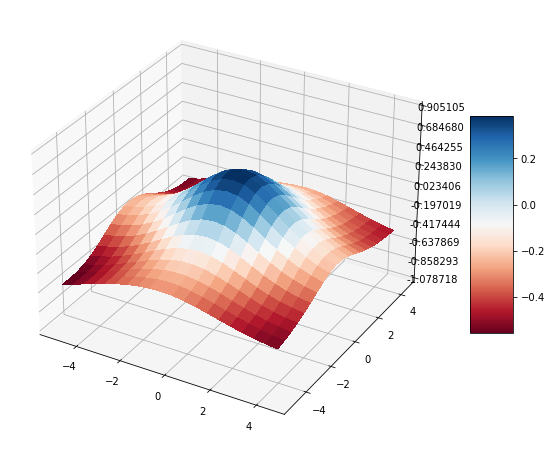

Surface after 900 epochs


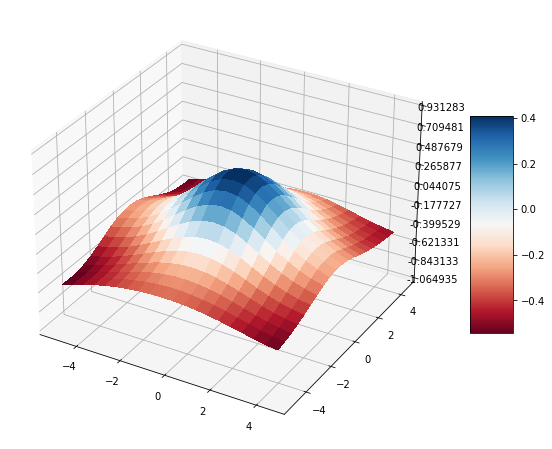

Real Surface


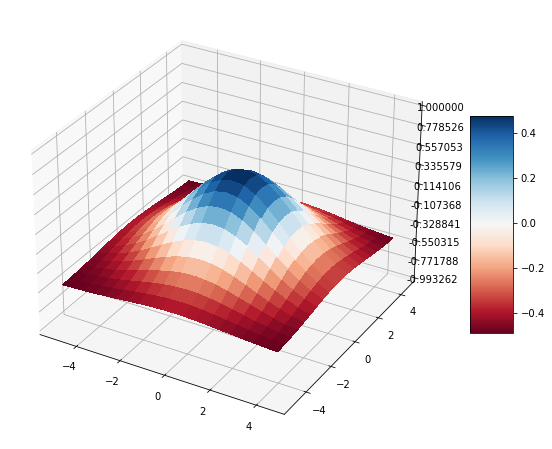

In [51]:
# Plot change over time
for i in range(len(outputs)):
    if i%100 == 0:
        print(f"Surface after {i} epochs")
        plot_3D(xx, yy, outputs[i])
print("Real Surface")
plot_3D(xx, yy, zz)

Real Surface


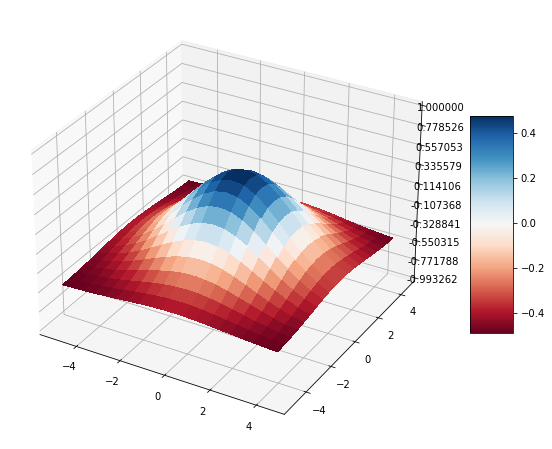

Surface with 2 layers after 1000 epochs


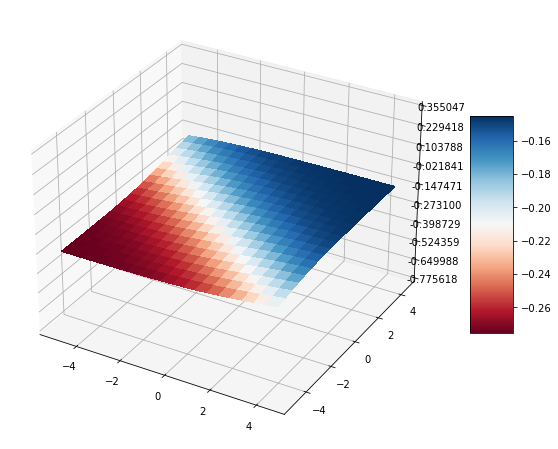

Surface with 4 layers after 1000 epochs


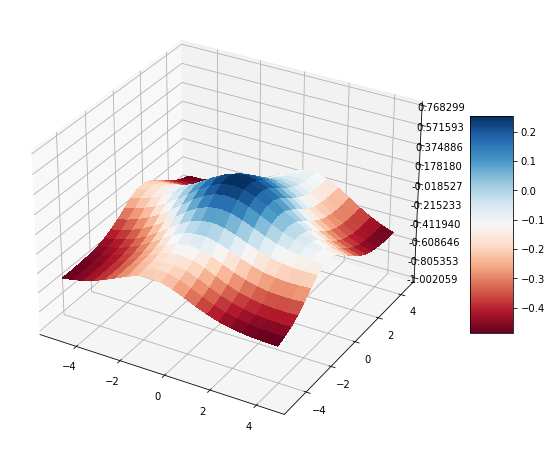

Surface with 8 layers after 1000 epochs


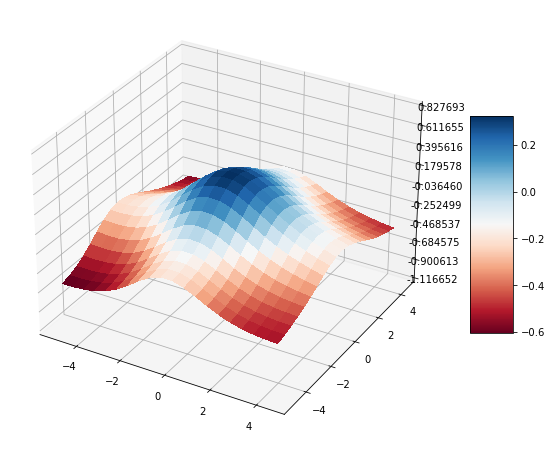

Surface with 12 layers after 1000 epochs


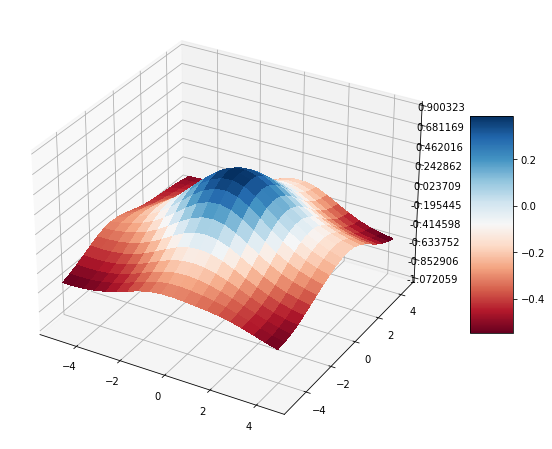

Surface with 16 layers after 1000 epochs


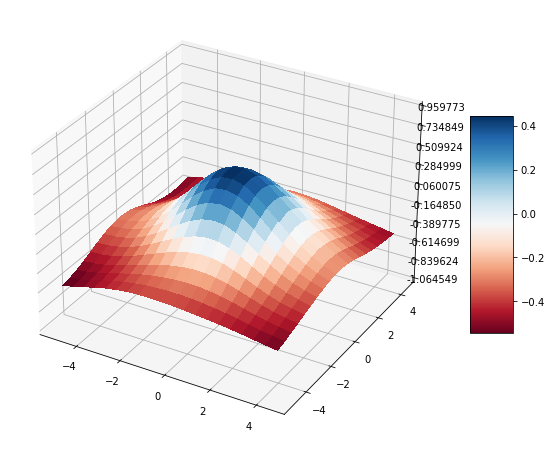

Surface with 20 layers after 1000 epochs


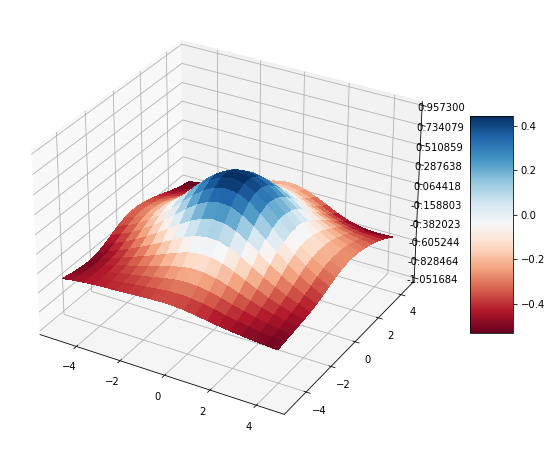

Surface with 24 layers after 1000 epochs


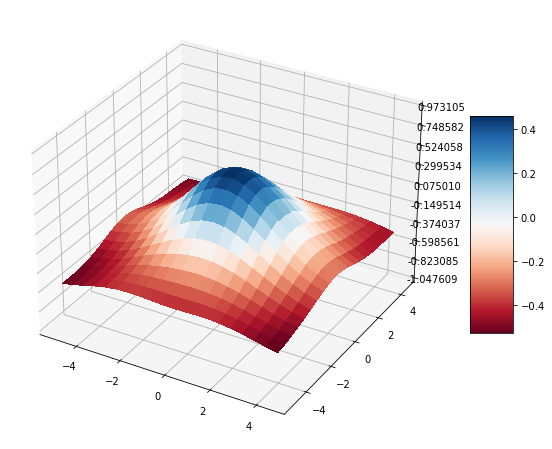

In [8]:
# Vary hidden layers
epochs = 1000
lr = 0.001
nHiddens = [2, 4, 8, 12, 16, 20, 24]

print("Real Surface")
plot_3D(xx, yy, zz)
for nHidden in nHiddens:
    ndata = len(xx)*len(yy)
    T = zz.reshape(ndata).copy()
    X = np.vstack([np.reshape(xx, (1, ndata)), np.reshape(yy,(1,ndata))])
    X = np.vstack([X, np.ones(X.shape[1])])
    W = np.random.rand(nHidden,X.shape[0])
    V = np.random.rand(1,nHidden+1)
    dW = np.zeros((W.shape[0], W.shape[1]))
    dV = np.zeros((V.shape[0], V.shape[1]))
    X_test = None
    T_test = None
    W_out, V_out, outputs, accuracy, errors, outputs_test, accuracy_test = backprop_3D(X, T, W, V, dW, dV, lr, X_test, T_test, epochs, nHidden, alpha=0.9, test = False)
    print(f"Surface with {nHidden} layers after {epochs} epochs")
    plot_3D(xx, yy, outputs[-1])

Real Surface


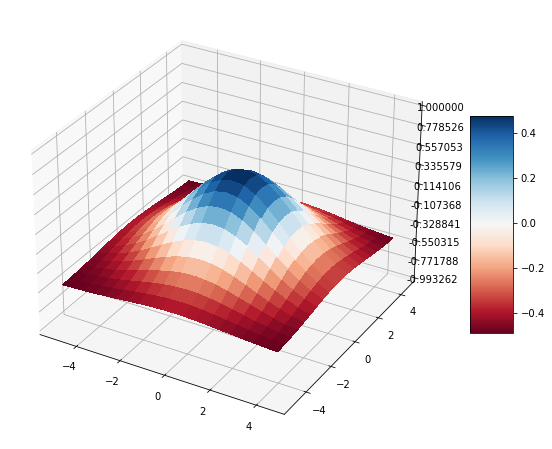

Surface with 2 layers after 1000 epochs


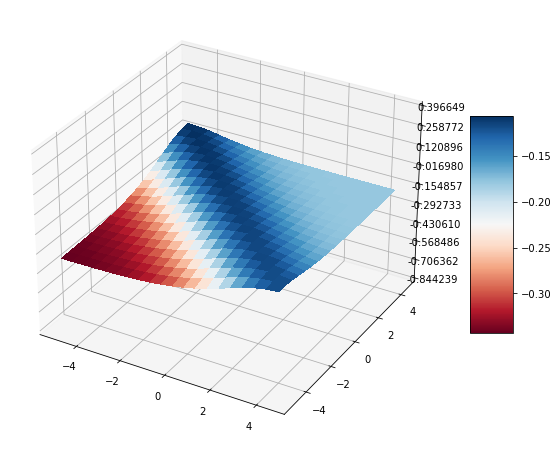

MSE curve for network with 2 layers 
Final error: 0.0581484276895959


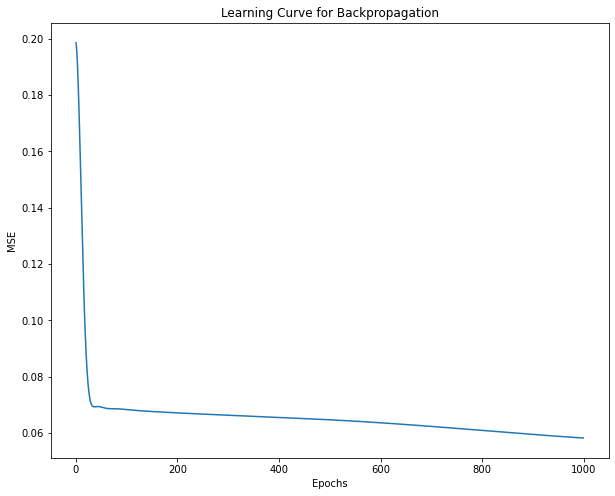

Surface with 4 layers after 1000 epochs


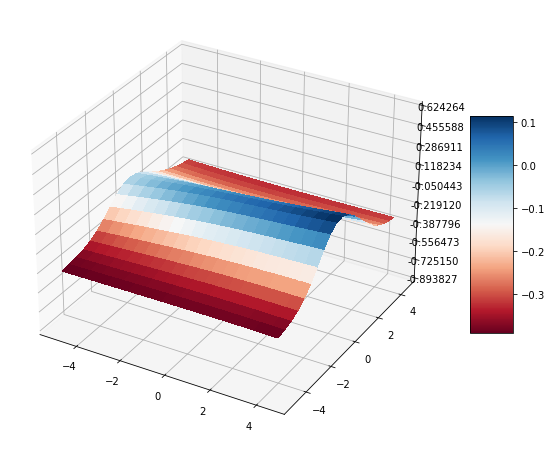

MSE curve for network with 4 layers 
Final error: 0.03967114655470561


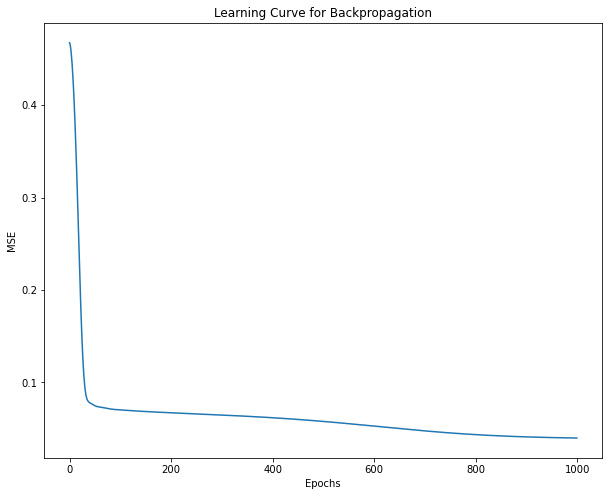

Surface with 8 layers after 1000 epochs


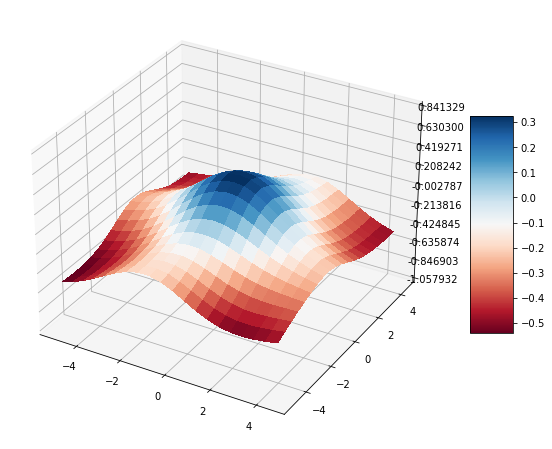

MSE curve for network with 8 layers 
Final error: 0.007400132380497362


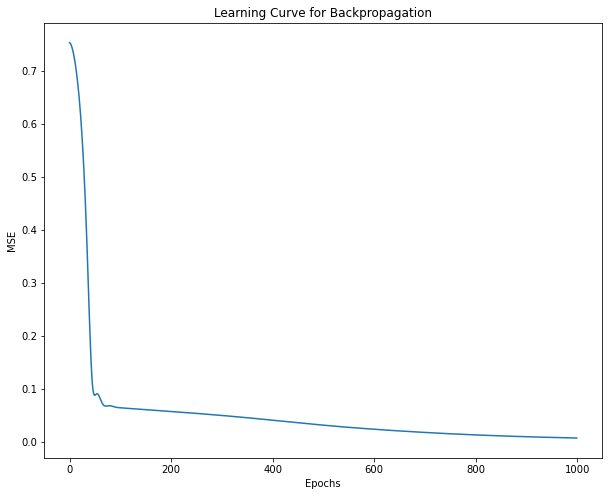

Surface with 12 layers after 1000 epochs


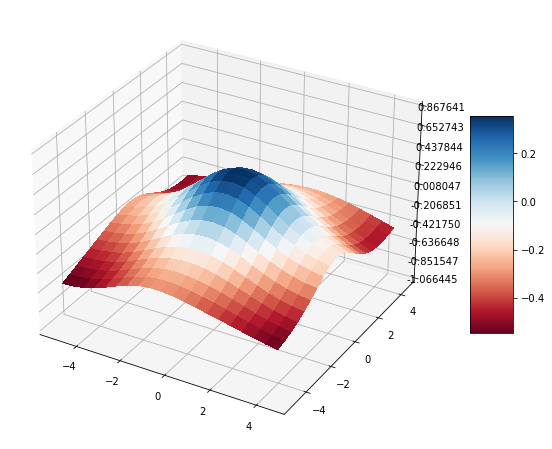

MSE curve for network with 12 layers 
Final error: 0.004255249762180354


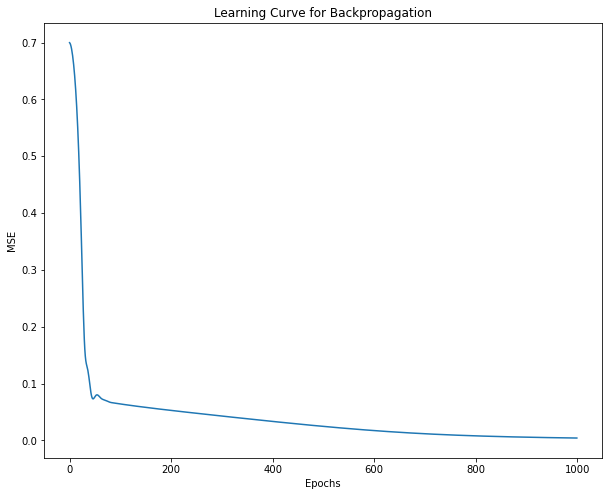

Surface with 16 layers after 1000 epochs


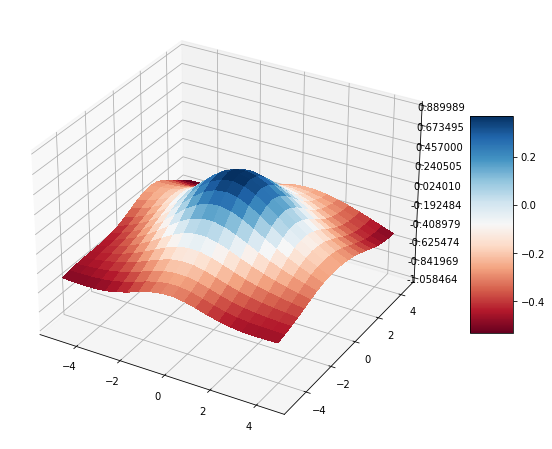

MSE curve for network with 16 layers 
Final error: 0.003150107786497416


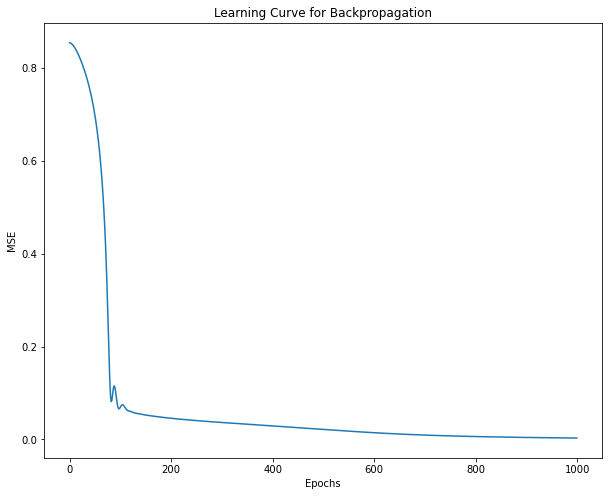

Surface with 20 layers after 1000 epochs


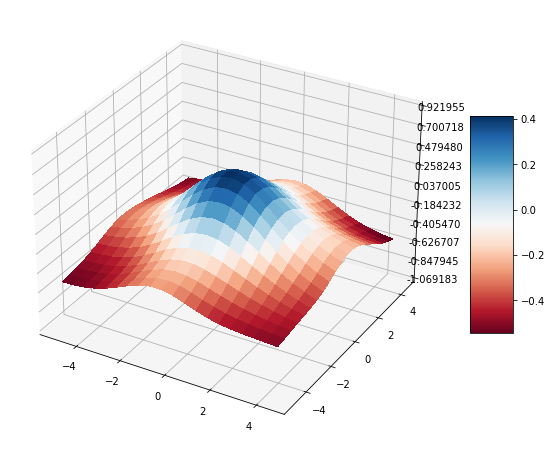

MSE curve for network with 20 layers 
Final error: 0.0027252595269740844


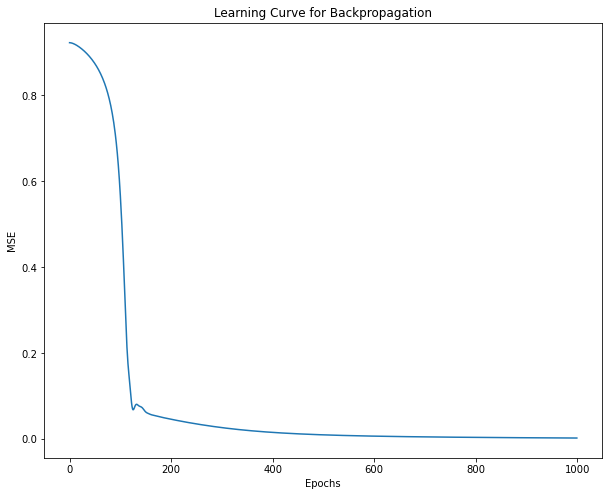

Surface with 24 layers after 1000 epochs


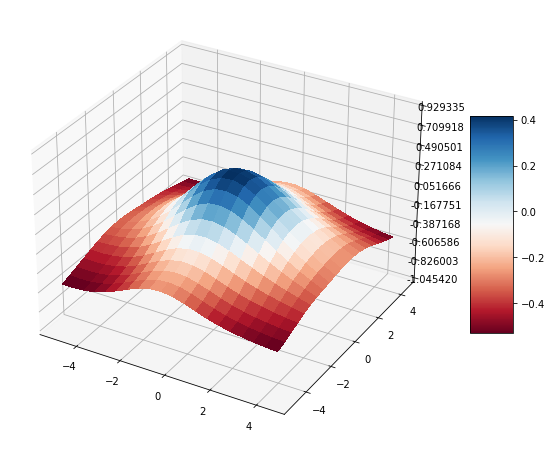

MSE curve for network with 24 layers 
Final error: 0.0020360808664110137


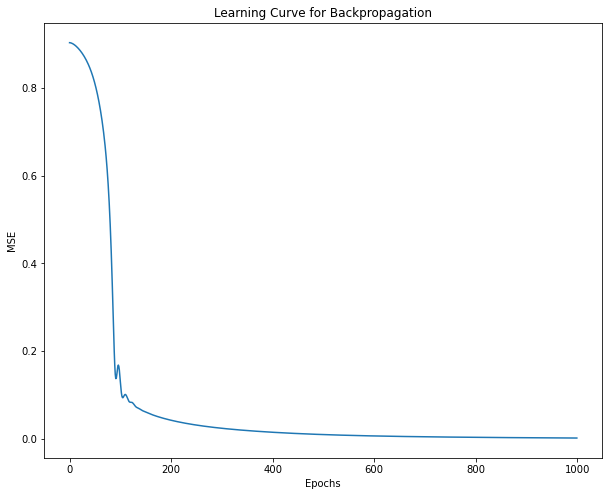

In [68]:
# Vary hidden layers
epochs = 1000
lr = 0.001
nHiddens = [2, 4, 8, 12, 16, 20, 24]

x = np.arange(-5,5,0.5)
y = np.arange(-5,5,0.5)
xx, yy = np.meshgrid(x, y)
zz = f(xx, yy)

print("Real Surface")
plot_3D(xx, yy, zz)
for nHidden in nHiddens:
    ndata = len(xx)*len(yy)
    T = zz.reshape(ndata).copy()
    X = np.vstack([np.reshape(xx, (1, ndata)), np.reshape(yy,(1,ndata))])
    X = np.vstack([X, np.ones(X.shape[1])])
    X_train, T_train, X_val, T_val = shuffle_and_split(X, T, 17)
    X_val = np.hstack((X_train, X_val))
    T_val = np.hstack((T_train, T_val))
    W = np.random.rand(nHidden,X.shape[0])
    V = np.random.rand(1,nHidden+1)
    dW = np.zeros((W.shape[0], W.shape[1]))
    dV = np.zeros((V.shape[0], V.shape[1]))
    W_out, V_out, outputs, accuracy, errors, outputs_test, errors_test = backprop_3D(X_train, T_train, W, V, dW, dV, lr, X, T, epochs, nHidden, alpha=0.9, test = True)
    
    print(f"Surface with {nHidden} layers after {epochs} epochs")
    plot_3D(xx, yy, outputs_test[-1])
    print(f"MSE curve for network with {nHidden} layers \n"+f"Final error: {errors_test[-1]}")
    plot_mse(errors_test)

Real Surface


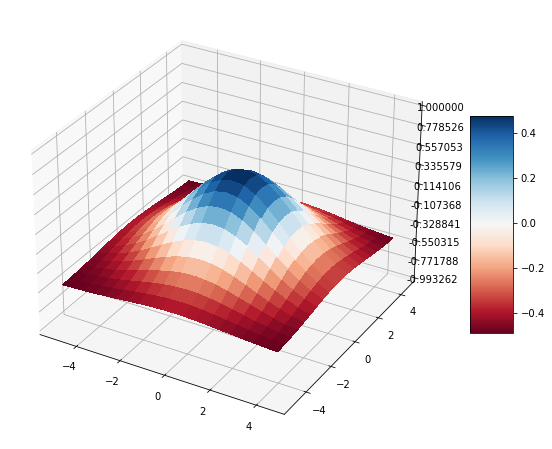

Surface with 16 layers after 1000 epochs 
Trained on 0.81 percent of data


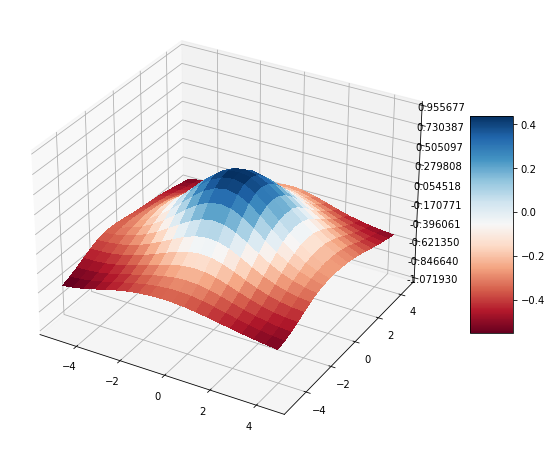

Final error: 0.001076522669454551


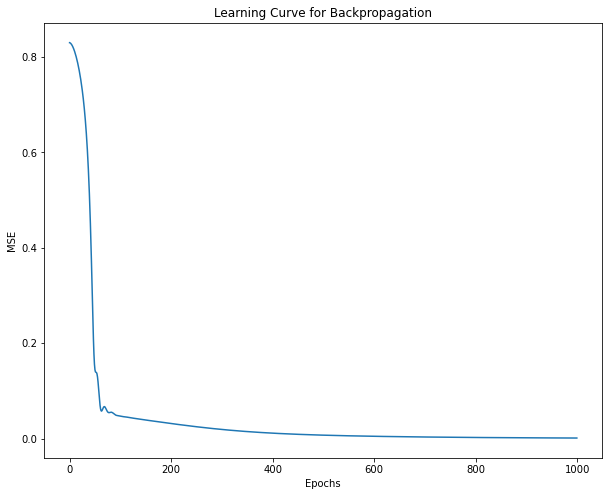

Surface with 16 layers after 1000 epochs 
Trained on 0.64 percent of data


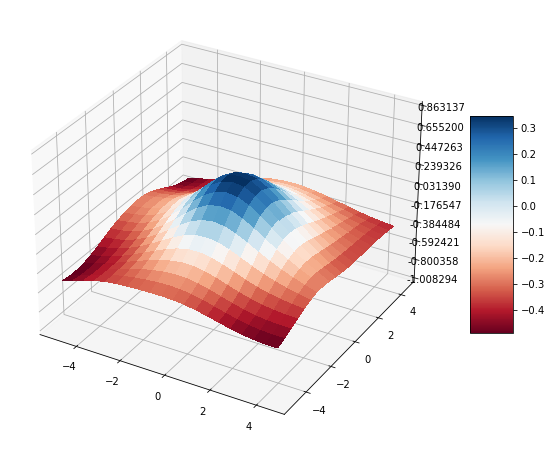

Final error: 0.004955861214417541


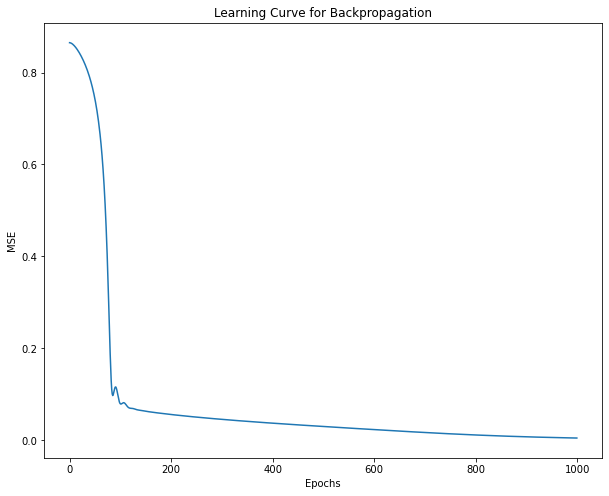

Surface with 16 layers after 1000 epochs 
Trained on 0.49 percent of data


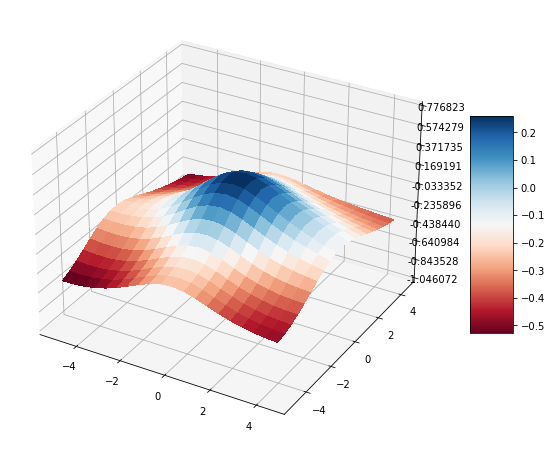

Final error: 0.010124669875153671


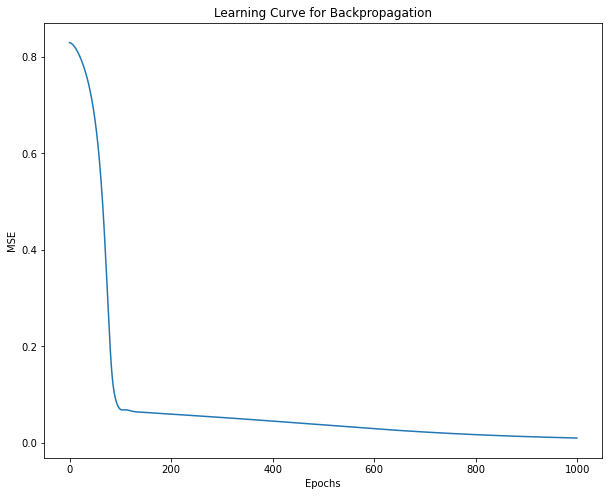

Surface with 16 layers after 1000 epochs 
Trained on 0.36 percent of data


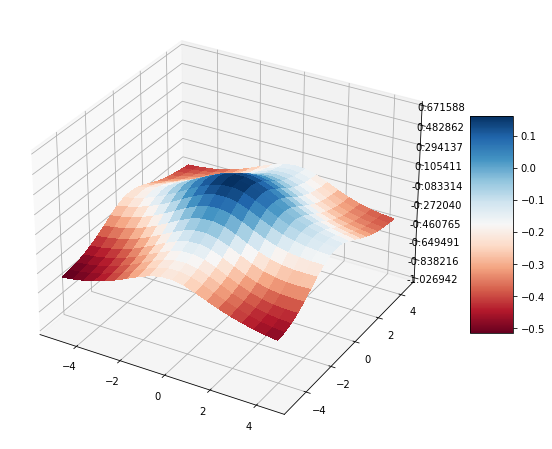

Final error: 0.01593413682533863


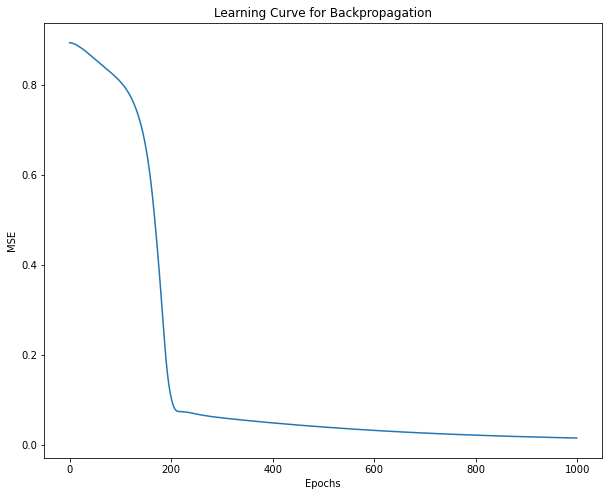

Surface with 16 layers after 1000 epochs 
Trained on 0.25 percent of data


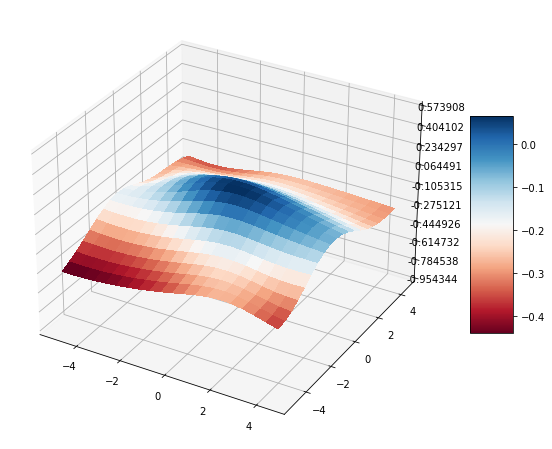

Final error: 0.028659452484434828


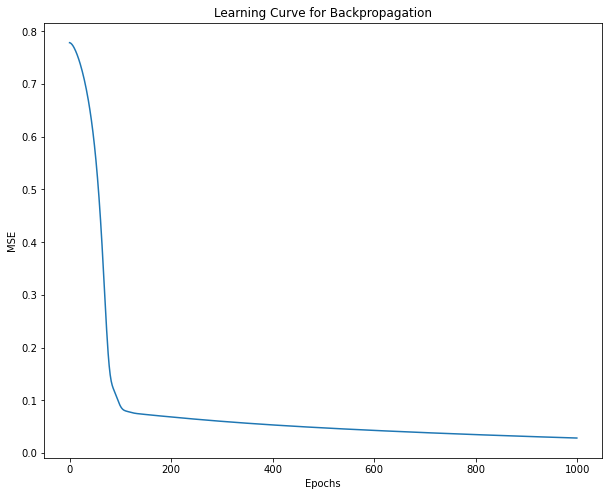

Surface with 16 layers after 1000 epochs 
Trained on 0.16 percent of data


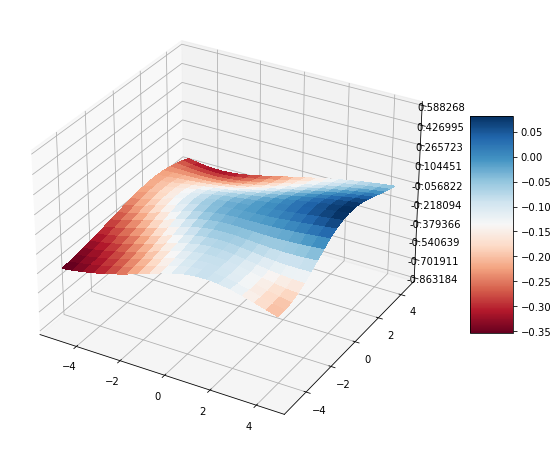

Final error: 0.05619499342518306


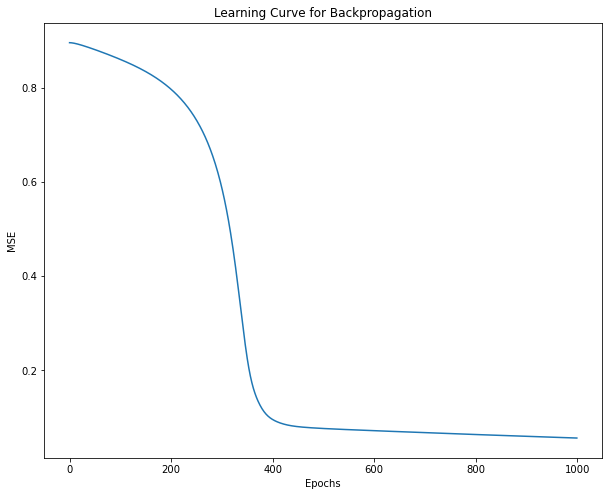

In [70]:
# Vary train %
epochs = 1000
lr = 0.001
nHidden = 16
splits = [18, 16, 14, 12, 10, 8]

x = np.arange(-5,5,0.5)
y = np.arange(-5,5,0.5)
xx, yy = np.meshgrid(x, y)
zz = f(xx, yy)

print("Real Surface")
plot_3D(xx, yy, zz)
for split in splits:
    ndata = len(xx)*len(yy)
    T = zz.reshape(ndata).copy()
    X = np.vstack([np.reshape(xx, (1, ndata)), np.reshape(yy,(1,ndata))])
    X = np.vstack([X, np.ones(X.shape[1])])
    X_train, T_train, X_val, T_val = shuffle_and_split(X, T, split)
    X_val = np.hstack((X_train, X_val))
    T_val = np.hstack((T_train, T_val))
    W = np.random.rand(nHidden,X.shape[0])
    V = np.random.rand(1,nHidden+1)
    dW = np.zeros((W.shape[0], W.shape[1]))
    dV = np.zeros((V.shape[0], V.shape[1]))
    W_out, V_out, outputs, accuracy, errors, outputs_test, errors_test = backprop_3D(X_train, T_train, W, V, dW, dV, lr, X, T, epochs, nHidden, alpha=0.9, test = True)
    
    print(f"Surface with {nHidden} layers after {epochs} epochs \n"+f"Trained on {split*split/(20*20)} percent of data")
    plot_3D(xx, yy, outputs_test[-1])
    print(f"Final error: {errors_test[-1]}")
    plot_mse(errors_test)

Real Surface


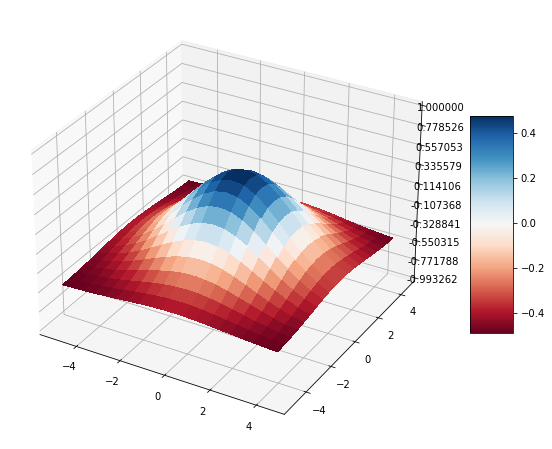

Surface with 16 layers after 100 epochs 
Trained on 0.81 percent of data


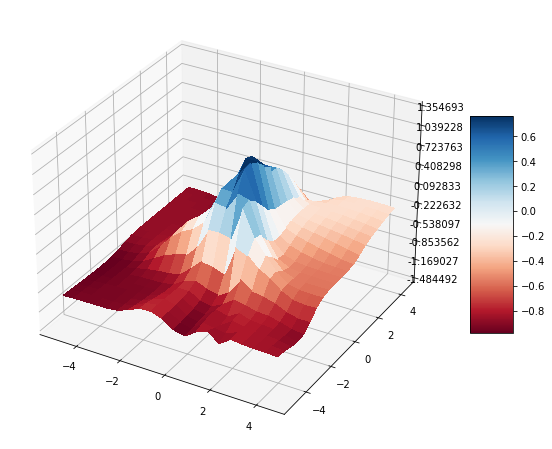

Final error: 0.21117937897323635


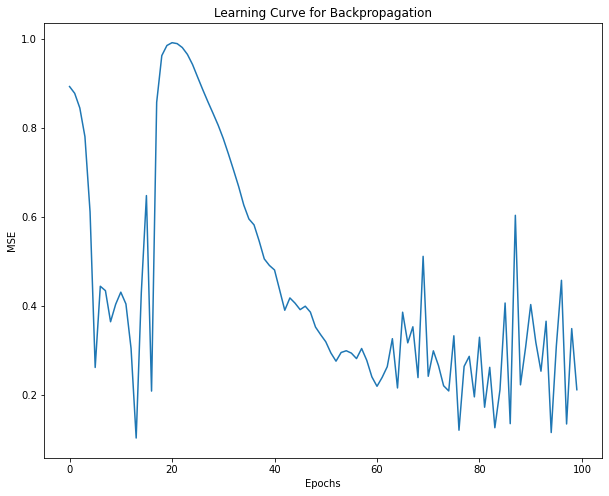

Surface with 16 layers after 100 epochs 
Trained on 0.64 percent of data


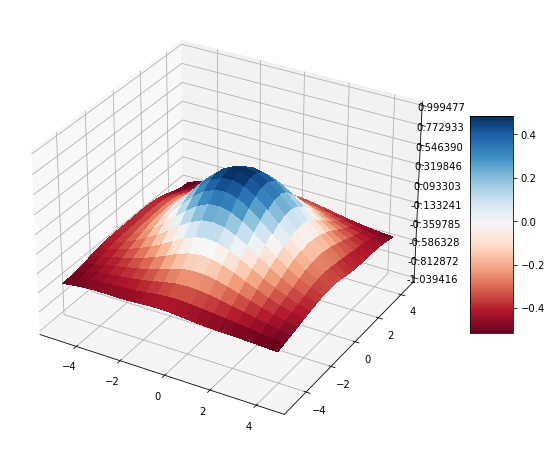

Final error: 0.0003518903338234372


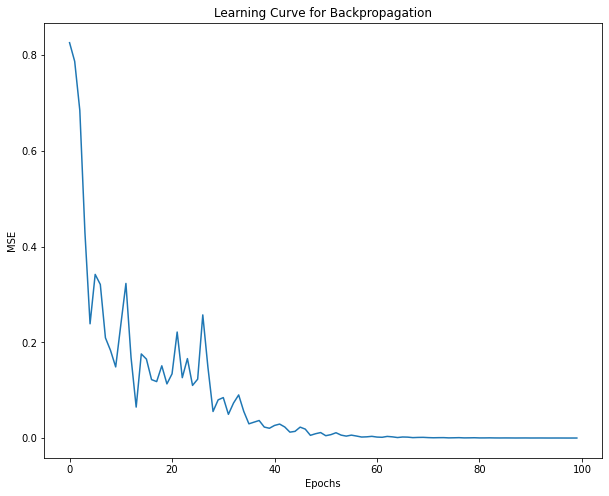

Surface with 16 layers after 100 epochs 
Trained on 0.49 percent of data


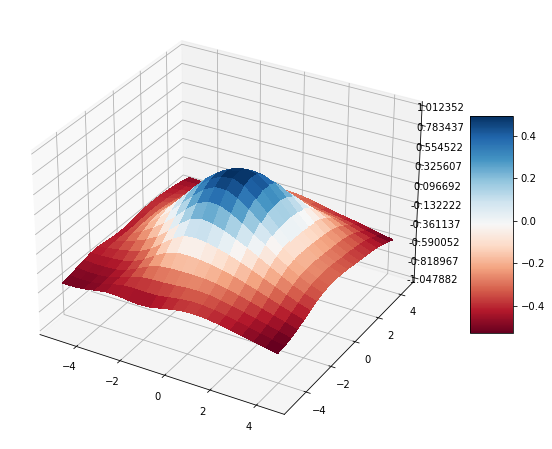

Final error: 0.0006903946309441976


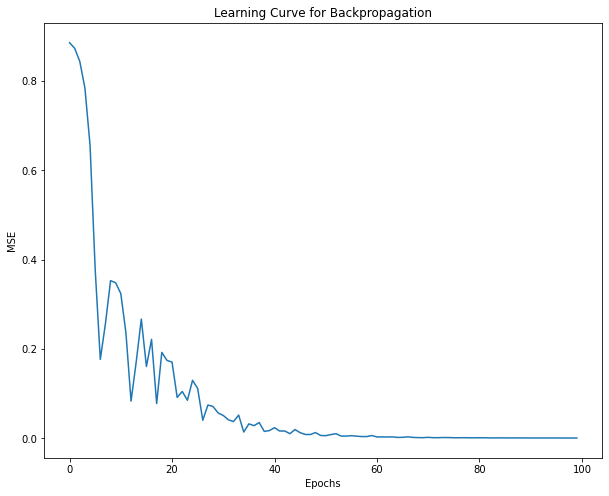

Surface with 16 layers after 100 epochs 
Trained on 0.36 percent of data


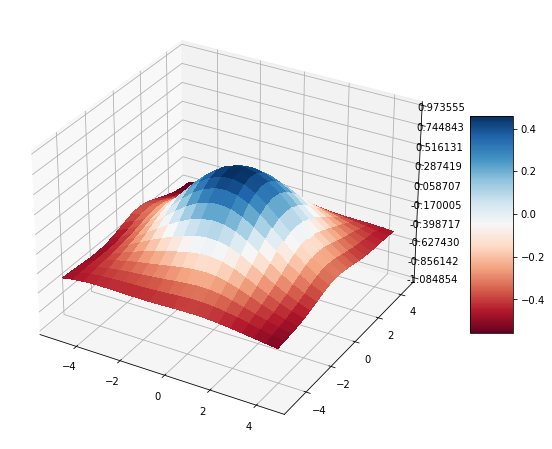

Final error: 0.0005080856685432829


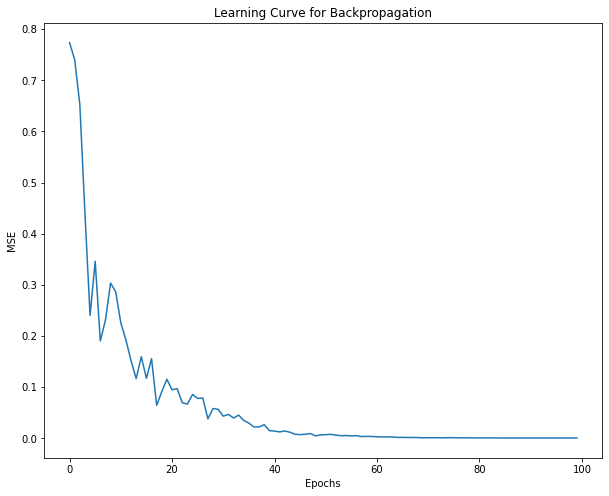

Surface with 16 layers after 100 epochs 
Trained on 0.25 percent of data


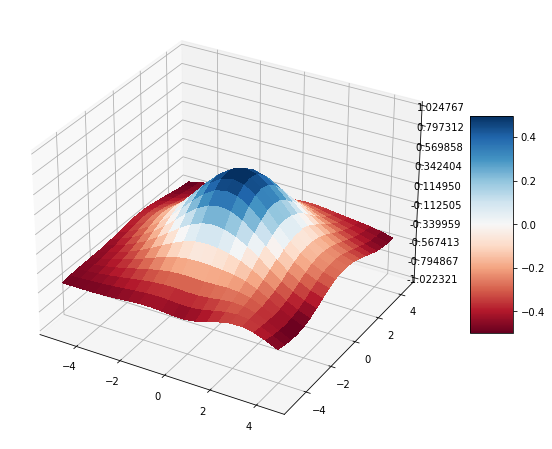

Final error: 0.0007264584809450023


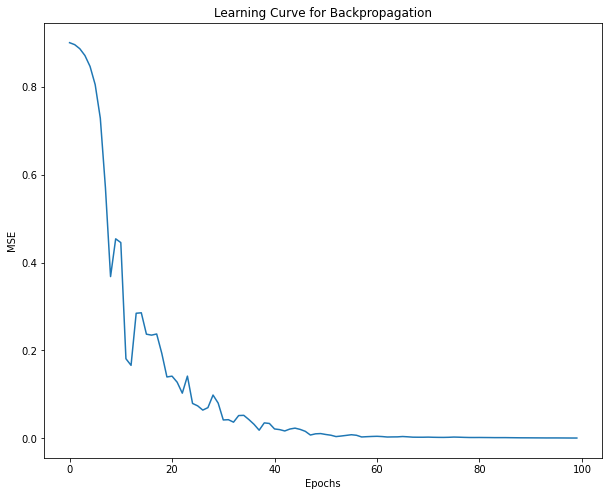

Surface with 16 layers after 100 epochs 
Trained on 0.16 percent of data


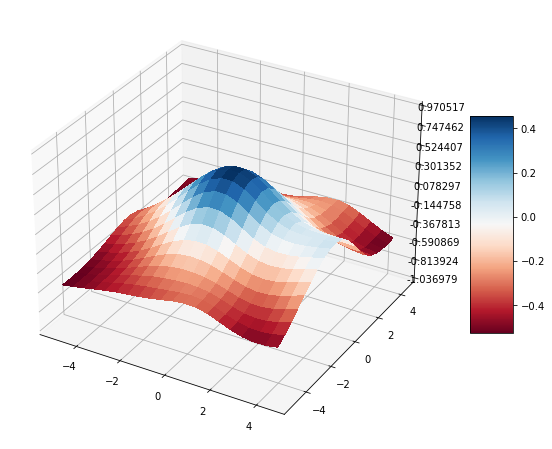

Final error: 0.0090977313001657


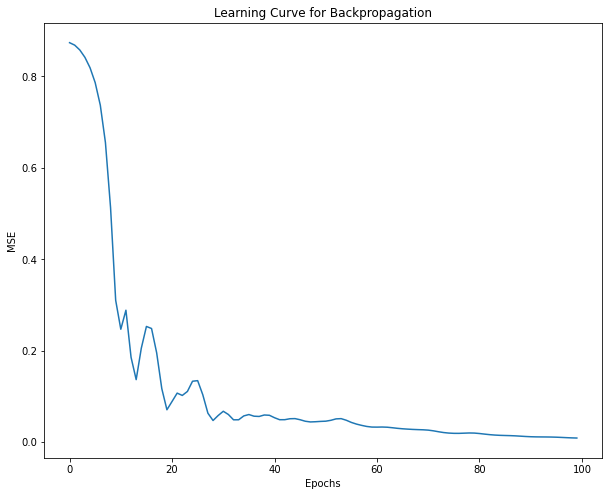

Surface with 16 layers after 100 epochs 
Trained on 0.04 percent of data


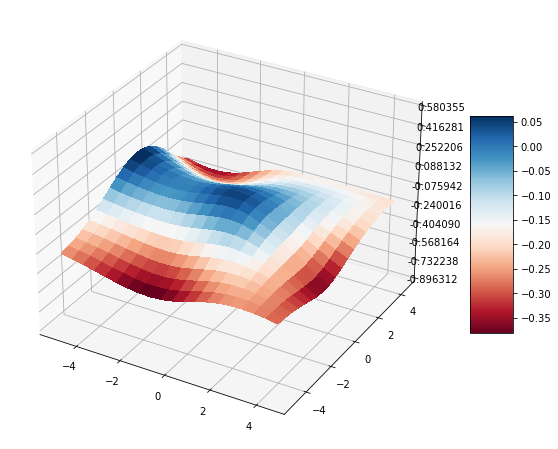

Final error: 0.04246140365829808


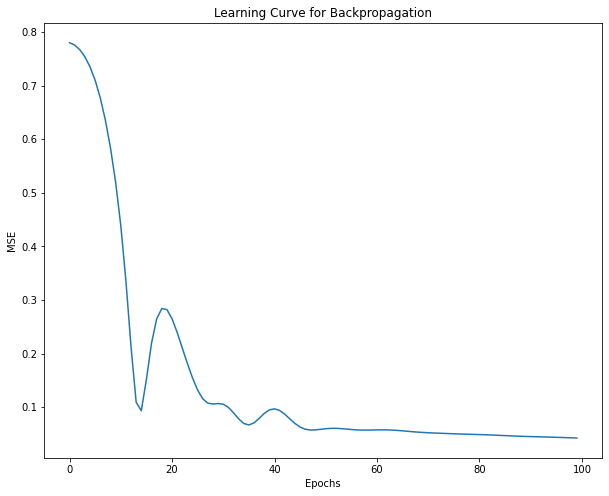

In [74]:
# Vary train % increased lr
epochs = 100
lr = 0.1
nHidden = 16
splits = [18, 16, 14, 12, 10, 8, 4]

x = np.arange(-5,5,0.5)
y = np.arange(-5,5,0.5)
xx, yy = np.meshgrid(x, y)
zz = f(xx, yy)

print("Real Surface")
plot_3D(xx, yy, zz)
for split in splits:
    ndata = len(xx)*len(yy)
    T = zz.reshape(ndata).copy()
    X = np.vstack([np.reshape(xx, (1, ndata)), np.reshape(yy,(1,ndata))])
    X = np.vstack([X, np.ones(X.shape[1])])
    X_train, T_train, X_val, T_val = shuffle_and_split(X, T, split)
    X_val = np.hstack((X_train, X_val))
    T_val = np.hstack((T_train, T_val))
    W = np.random.rand(nHidden,X.shape[0])
    V = np.random.rand(1,nHidden+1)
    dW = np.zeros((W.shape[0], W.shape[1]))
    dV = np.zeros((V.shape[0], V.shape[1]))
    W_out, V_out, outputs, accuracy, errors, outputs_test, errors_test = backprop_3D(X_train, T_train, W, V, dW, dV, lr, X, T, epochs, nHidden, alpha=0.9, test = True)
    
    print(f"Surface with {nHidden} layers after {epochs} epochs \n"+f"Trained on {split*split/(20*20)} percent of data")
    plot_3D(xx, yy, outputs_test[-1])
    print(f"Final error: {errors_test[-1]}")
    plot_mse(errors_test)

In [97]:
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error

import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.simplefilter("ignore", category=ConvergenceWarning)

beta = 0.2
gamma = 0.1
n = 10
timeMax = 1501
timeSeries = np.zeros(timeMax+5)
def mackey_glass(t, t25):
    return t + beta*t25 / (1 + t25**n) - gamma*t


timeSeries[0] = 1.5
for t in range(1,timeMax+5):
    if t-26 < 0:
        timeSeries[t] = mackey_glass(timeSeries[t-1], 0)
    else:
        timeSeries[t] = mackey_glass(timeSeries[t-1], timeSeries[t-26])
    

def input_vector(t):
    return np.array([timeSeries[t-20], timeSeries[t-15], timeSeries[t-10], timeSeries[t-5], timeSeries[t], 1])


X = []
T = []
for t in range(301,1501):
    X.append(input_vector(t))
    T.append(timeSeries[t+5])
X = np.array(X)
T = np.array(T)

X_train, X_test, T_train, T_test = train_test_split(X, T, test_size = 200/1200, shuffle=False)

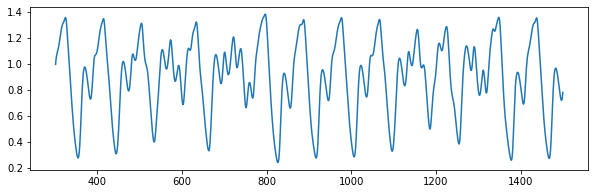

In [50]:
t = np.arange(301,1501,1)
plt.rcParams['figure.figsize'] = [10, 3]
plt.plot(t, T)
plt.show()

In [116]:
epochs = 200
lr = 0.05
alpha = 0.9
gamma = 1e-4
eStop = 1e-4
valFrac = 1/5
nNodes = []
for nh1 in [3, 4, 5]:
    for nh2 in [2, 4, 6]:
        nNodes.append((nh1, nh2))

for nNode in nNodes:
    mlp = MLPRegressor(hidden_layer_sizes=nNode, activation='logistic', solver='adam', learning_rate_init=lr, alpha = gamma, max_iter=epochs, early_stopping=True, tol=eStop, validation_fraction=valFrac)
    scores = cross_val_score(mlp, X_train, T_train, cv=10, scoring='neg_mean_squared_error')
    print(f"nh1: {nNode[0]}, nh2: {nNode[1]}")
    print(f"MSE: {scores.mean()*(-1)}, standard deviation: {scores.std()}")

nh1: 3, nh2: 2
MSE: 0.026020365523370594, standard deviation: 0.03803951091481167
nh1: 3, nh2: 4
MSE: 0.019282909805194613, standard deviation: 0.03488821149178294
nh1: 3, nh2: 6
MSE: 0.0038526104425571474, standard deviation: 0.0027431631111064676
nh1: 4, nh2: 2
MSE: 0.024459424841101272, standard deviation: 0.03644223438642106
nh1: 4, nh2: 4
MSE: 0.027139920009156066, standard deviation: 0.04120820785383973
nh1: 4, nh2: 6
MSE: 0.013426103526198056, standard deviation: 0.033013362965949304
nh1: 5, nh2: 2
MSE: 0.024043607059238508, standard deviation: 0.0439078664811441
nh1: 5, nh2: 4
MSE: 0.013223487402850134, standard deviation: 0.031711055796797005
nh1: 5, nh2: 6
MSE: 0.03209328048964568, standard deviation: 0.046165762499186594


nh1: 5, nh2: 2
Test MSE: 0.0018663817730834537
nh1: 4, nh2: 6
Test MSE: 0.0012682281026901948


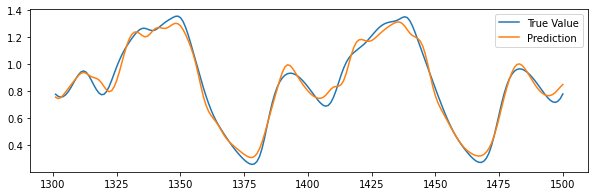

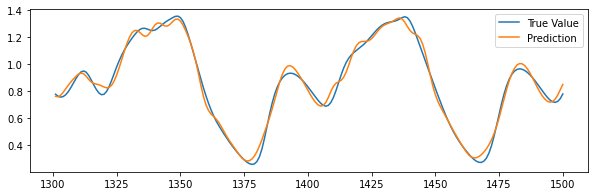

In [125]:
nNodes = [(5, 2), (4, 6)]
epochs = 200
lr = 0.05
alpha = 0.9
gamma = 1e-4
eStop = 1e-4
valFrac = 1/5
t = np.arange(1301,1501,1)

for nNode in nNodes:
    mlp = MLPRegressor(hidden_layer_sizes=nNode, activation='logistic', solver='adam', alpha=gamma, learning_rate_init=lr, max_iter=epochs, early_stopping=True, tol=eStop, validation_fraction=valFrac)
    mlp.fit(X_train, T_train)
    T_predict = mlp.predict(X_test)
    mse = mean_squared_error(T_test, T_predict)
    print(f"nh1: {nNode[0]}, nh2: {nNode[1]}")
    print(f"Test MSE: {mse}")
    plt.figure()
    plt.plot(t, T_test)
    plt.plot(t, T_predict)
    plt.legend(["True Value", "Prediction"])
    

In [105]:
# Add noise to data
# Large lambda leads to underfitting
epochs = 200
lr = 0.01
alpha = 0.9
eStop = 1e-4
valFrac = 1/5

sigmas = [0.05, 0.1, 0.15]
nh1 = 4
nh2s = [3, 6, 9]
gammas = [1e-1, 1e-3, 1e-5]
sigma_nh2 = np.zeros((3, 3))
sigma_nh2_std = np.zeros((3,3))
sigma_gamma = np.zeros((3,3))
sigma_gamma_std = np.zeros((3,3))

for s, sigma in enumerate(sigmas):
    T_train_noise = T_train.copy()
    for t in T_train_noise:
        t = t + np.random.normal(0, sigma)
    for n,nh2 in enumerate(nh2s):
        mlp = MLPRegressor(hidden_layer_sizes=(nh1, nh2), activation='logistic', solver='adam', alpha=1e-4, learning_rate_init=lr, max_iter=epochs, early_stopping=True, tol=eStop, validation_fraction=valFrac)
        scores = cross_val_score(mlp, X_train, T_train, cv=5, scoring='neg_mean_squared_error')
        sigma_nh2[s, n] = scores.mean()*(-1)
        sigma_nh2_std[s,n] = scores.std()
    for g, gamma in enumerate(gammas):
        mlp = MLPRegressor(hidden_layer_sizes=(nh1, 6), activation='logistic', solver='adam', alpha=gamma, learning_rate_init=lr, max_iter=epochs, early_stopping=True, tol=eStop, validation_fraction=valFrac)
        scores = cross_val_score(mlp, X_train, T_train, cv=5, scoring='neg_mean_squared_error')
        sigma_gamma[s,g] = scores.mean()*(-1)
        sigma_gamma_std[s, g] = scores.std()
        
print(f"MSE for sigma= {sigmas} and nh2= {nh2s}")
print(sigma_nh2)
print(f"STD for sigma= {sigmas} and nh2= {nh2s}")
print(sigma_nh2_std)
print(f"STD for sigma= {sigmas} and gamma={gammas}")
print(sigma_gamma)
print(f"MSE for sigma= {sigmas} and gamma={gammas}")
print(sigma_gamma_std)

MSE for sigma= [0.05, 0.1, 0.15] and nh2= [3, 6, 9]
[[0.04742234 0.02323177 0.01052011]
 [0.0421218  0.01990145 0.0464977 ]
 [0.02627276 0.01223788 0.01467869]]
STD for sigma= [0.05, 0.1, 0.15] and nh2= [3, 6, 9]
[[0.04217527 0.01831693 0.00521493]
 [0.02998297 0.02030688 0.04156617]
 [0.02044348 0.00742451 0.0060307 ]]
STD for sigma= [0.05, 0.1, 0.15] and gamma=[0.1, 0.001, 1e-05]
[[0.02301955 0.0143116  0.02565735]
 [0.01919713 0.01573814 0.01157238]
 [0.01867304 0.01030153 0.03509513]]
MSE for sigma= [0.05, 0.1, 0.15] and gamma=[0.1, 0.001, 1e-05]
[[0.00663365 0.00479984 0.01316022]
 [0.00447947 0.00468714 0.00503803]
 [0.00377541 0.00332157 0.04057519]]
